In [36]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# **An Exploratory Analysis of Traffic in the Copenhagen Metropolitan Area**

## *Website*
#### Link to explainer notebook: https://github.com/witting97/02806-finalproject/blob/main/explainer.ipynb

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import holidays
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import math
from sklearn import metrics

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib

sns.set(rc={'figure.figsize': (15, 6)})
%config InlineBackend.figure_format = 'retina'
pd.options.mode.chained_assignment = None

# Heatmapping
import folium

# Output markup
from jinja2.utils import markupsafe
markupsafe.Markup()

# Bokeh
from bokeh.io import output_notebook, curdoc
from bokeh.models import ColumnDataSource, HoverTool, FactorRange
from bokeh.layouts import layout, gridplot
from bokeh.models.widgets import Tabs, Panel
# To display bokeh in deepnote
from bokeh.plotting import figure, output_file, save
from IPython.core.display import display, HTML
import tempfile

#reset_output() # If you are having issues with visualizing Bokeh plots in the notebook try to uncomment this line
output_notebook()  # This is to make sure that bokeh plots in the notebook

from datetime import datetime
import warnings

warnings.filterwarnings("ignore")
sns.set_palette('colorblind')

# Table of contents

- [**An Exploratory Analysis of Traffic in the Copenhagen Metropolitan Area**](attachment:./#**An-Exploratory-Analysis-of-Traffic-in-the-Copenhagen-Metropolitan-Area**)
  * [*Explainer Notebook*](attachment:./#*Explainer-Notebook*)
- [Motivation](attachment:./#Motivation)
- [Basic stats](attachment:./#Basic-stats)
  * [Traffic measurement data](attachment:./#Traffic-measurement-data)
    * [Traffic counter locations and activity](attachment:./#Traffic-counter-locations-and-activity)
  * [COVID-19 data](attachment:./#COVID-19-data)
  * [Gas prices dataframe and price indexes](attachment:./#Gas-prices-dataframe-and-price-indexes)
    * [Adjusting for inflation](attachment:./#Adjusting-for-inflation)
    * [Removing noise from the data](attachment:./#Removing-noise-from-the-data)
- [Data Analysis](attachment:./#Data-Analysis)
  * [Traffic during COVID in 2020](attachment:./#Traffic-during-COVID-in-2020)
    * [Data distributions](attachment:./#Data-distributions)
    * [Hourly plots during COVID vs before](attachment:./#Hourly-plots-during-COVID-vs-before)
  * [Predicting traffic with gas prices](attachment:./#Predicting-traffic-with-gas-prices)
    * [Setup](attachment:./#Setup)
    * [Baseline model](attachment:./#Baseline-model)
    * [Linear Regression model](attachment:./#Linear-Regression-model)
    * [Artificial neural network](attachment:./#Artificial-neural-network)
    * [Model summary](attachment:./#Model-summary)
- [Genre](attachment:./#Genre)
  * [Visual narrative](attachment:./#Visual-narrative)
  * [Narrative structuring](attachment:./#Narrative-structuring)
- [Visualizations](attachment:./#Visualizations)
  * [COVID-19 and traffic](attachment:./#COVID-19-and-traffic)
    * [Overview plots](attachment:./#Overview-plots)
    * [Bokeh plot](attachment:./#Bokeh-plot)
  * [Visualizing geodata](attachment:./#Visualizing-geodata)
  * [Visualizing predicted data](attachment:./#Visualizing-predicted-data)
- [Discussion](attachment:./#Discussion)
  * [Traffic prediction](attachment:./#Traffic-prediction)
  * [Traffic and COVID-19](attachment:./#Traffic-and-COVID-19)
- [Contributions](attachment:./#Contributions)
- [References](attachment:./#References)

# Motivation

During the past few years, the societal behaviour regarding transportation has changed. At first, COVID-19 lockdowns throughout Denmark put limitations or different requirements on the way we travel. More recently, the rise of gas prices may have a similar impact on travel patterns. We will be doing an exploratory analysis of traffic behavior in the central Copenhagen area, to identify specific patterns and behaviour.

We have chosen three data sets to perform this analysis on:
- COVID-19 dataset for Denmark.
- Traffic data from major roads in Copenhagen (The Danish Road Directorate).
- Historical gas prices dataset.

We want to explore the possible patterns which relate between traffic and COVID, especially during the initial phase of restrictions in Denmark. In addition, it would be interesting to see if there is any other correlation with traffic thus we have chosen the historical gas price data set to see if increasing prices led to reduced traffic activity. In addition, is it possible to predict traffic using gas prices? By investigating these questions, we aim to give the reader an impression of how lockdowns and increasing gas prices have impacted our driving habits.

# Basic stats
<!--
    * Write about your choices in data cleaning and preprocessing
    * Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis. -->

We will now present our data and explain how we cleaned and preprocessed it such that it can be used in the analyses.

## Traffic measurement data

Traffic data from Vejdirektoratet (the Danish Road Directorate) is made available for free through their platform [iMastra](https://www.vejdirektoratet.dk/side/imastra), from which we have extracted data of three measuring stations in Copenhagen from 2016-2022.

The raw data we extracted was in the form of an Excel pivot table containing all the measurements from the extracted time period, as well as additional information about the measurements (e.g. at which measuring station it was recorded). We cleaned this data and placed it in the `df_traffic` dataframe in which one row represents one entry of recorded date of a particular measuring station at a particular time. The data properties are as follows:

* **`date`:** The date and time that the sample was recorded. The timestamps are in intervals of one hour (24h format), meaning that a traffic count of 500 at time 00:00 means that 500 cars had passed by the measuring station between 00:00-01:00.
* **`traffic_count`:** The number of cars that were recorded.
* **`street`:** The street where the measuring station was placed.
* **`direction`:** A variable representing the direction of the street, *T* meaning 'total traffic'/bidirectional.
* **`is_public_holiday`:** Self-explanatory.
* **`is_weekend`:** Self-explanatory.
* **`coordinates`:** The coordinates of the measuring station. These coordinates *can* be obtained through the iMastra platform; however, the data is not contained in the exported data file. Therefore, we are manually setting the coordinates for each station in the `match_coordinates` function.

<!--we could've reduced overhead/duplicate code/redundancy (?) by e.g. making it simpler to lookup to data of a measuring station from its id - currently we use street name which is a bit annoying. could've made a dataframe for the measuring stations with each their street name, id and coordinates, and then a dataframe for the measurement info (date, traffic_count, is_public_holiday, is_weekend).-->

In [3]:
# Define dates of key events
FIRST_CASE = datetime.strptime('27-02-2020', '%d-%m-%Y')
FIRST_LOCKDOWN = datetime.strptime('11-03-2020', '%d-%m-%Y')
FIRST_REOPENING = datetime.strptime('15-04-2020', '%d-%m-%Y')
ALL_RESTRICTIONS_GONE = datetime.strptime('31-01-2022', '%d-%m-%Y')
UKRAINE_RUSSIA_WAR = datetime.strptime('24-02-2022', '%d-%m-%Y')
PUBLIC_HOLIDAYS = holidays.DK()

COVID_DATES = [FIRST_CASE, FIRST_LOCKDOWN, FIRST_REOPENING]

# Match a measuring station's street name w. hardcoded coordinate set
def match_coordinates(street_name):
    if 'Strandvejen' in street_name:
        return [55.719538, 12.576936]
    elif 'Tagensvej' in street_name:
        return [55.702304, 12.550045]
    elif 'Mellem TSA 1 og 2' in street_name:
        return [55.7190609, 12.4964424]
    else:
        raise NotImplementedError('Missing coordinates for ' + street_name)

In [5]:
# Read raw HTML data into dataframes and collect them in a list
data_paths = ['2016_traffic.xls', '2017_traffic.xls', '2018_traffic.xls', '2019_traffic.xls', '2020_traffic.xls',
              '2021_traffic.xls', '2022_traffic.xls']
df_all_years = [pd.read_html(traffic_path, header=4, thousands=r'.') for traffic_path in data_paths]
dfs = []

# For each year in the dataset
for df_year in df_all_years:
    # For each week dataframe of that year
    for i in range(1, len(df_year), 2):
        metadata = df_year[i - 1]
        direction = metadata.iloc[2, 1]
        street = metadata.iloc[1, 3]
        year = metadata.iloc[:, 1].iloc[4][-4:]

        df = df_year[i]
        #df = df.set_index(df.columns[0])

        hours = list(df['Tid\\Dato'].iloc[:24].str[:5])
        dates = list(df.columns[1:][:-1]
                     .str.replace('/', '-', regex=True)
                     .str.replace('*', '', regex=True) + '-' + year)

        datetimes = [datetime.strptime(date + ' ' + hour, '%d-%m-%Y %H:%M') for date in dates for hour in hours]
        is_public_holiday = [date in PUBLIC_HOLIDAYS for date in datetimes]
        is_weekend = [date.weekday() >= 5 for date in datetimes]
        counts = np.asarray([list(df[col].iloc[:24]) for col in df.iloc[:, 1:-1]])
        counts = counts.flatten()

        df_week = pd.DataFrame(list(zip(datetimes, counts, [street] * len(counts), [
            direction] * len(counts), is_public_holiday, is_weekend)),
                               columns=['date', 'traffic_count', 'street', 'direction', 'is_public_holiday',
                                        'is_weekend'])

        dfs.append(df_week)

df_traffic = pd.concat(dfs)

# Removing all trailing and leading nans in first and last week
df_traffic = df_traffic[~df_traffic[['date', 'street']]
    .duplicated(keep=False) | df_traffic[['traffic_count']].notnull().any(axis=1)]
df_traffic = df_traffic.sort_values(by='date', ascending=True)
df_traffic = df_traffic.loc[df_traffic['date'] < '26-04-2022']

# Add coordinates to dataframe
df_traffic['coordinates'] = df_traffic['street'].apply(match_coordinates)

### Traffic counter locations and activity

In the map below, the three traffic counters are shown - some additional data can be seen upon clicking the measuring stations. Two exist on major roads in Nørrebro and Østerbro, while the third is placed at the beginning of Hillerødmotorvejen by Utterslev Mose. The circles' sizes indicate the total number of cars measured on the location since the first of October 2019. It is clear that the counter at Hillerødmotovejen sees a lot more traffic than the other two, aligning with expectations that a highway will be busier than roads, although major, in a city.

We selected the chosen locations so that we cover busy commuting areas (Hillerødmotorvejen) as well as busy intercity roads (Nørrebro and Strandvejen/Østerbro); furthermore, the measuring stations are all placed at quite central traffic node, giving us a good amount of data to work with.

In [6]:
# Create folium map of Copenhagen
lat, lon = 55.70, 12.52
fmap = folium.Map([lat, lon], zoom_start=12, min_zoom=10)

# Create clickable map markers for each measuring station
df_traffic_counts = df_traffic.groupby(['street']).traffic_count.sum().reset_index()
for street in df_traffic.street.unique():
    row = df_traffic.loc[df_traffic['street'] == street]
    total_measurements = int(df_traffic_counts.loc[df_traffic_counts['street'] == street].traffic_count)
    popup = '<strong>Name:</strong> {}\n<strong>Total:</strong> {}\n'.format(street, total_measurements)
    folium.Marker(location=match_coordinates(street), popup=popup, tooltip='<strong>{}</strong>'.format(street)).add_to(fmap)

# Get all data from right before covid started until now
geo_start_date = datetime(2019, 10, 1)
geo_end_date = datetime.now()
mask = (df_traffic['date'] > geo_start_date) & (df_traffic['date'] <= geo_end_date)
df_covid_traffic = df_traffic.loc[mask]

# Add 
df_covid_traffic_counts = df_covid_traffic.groupby(['street']).traffic_count.sum().reset_index()
for street in df_covid_traffic.street.unique():
    row = df_covid_traffic.loc[df_covid_traffic['street'] == street]
    (x,y) = match_coordinates(street)
    total_measurements = int(df_covid_traffic_counts.loc[df_covid_traffic_counts['street'] == street].traffic_count)
    folium.Circle(
        location=(x,y),
        radius= 0.5*math.sqrt(total_measurements),
        color='crimson',
        opacity=0.8,
        fill=True,
        fill_color='crimson',
        fill_opacity=0.3
    ).add_to(fmap)

fmap

Make this Notebook Trusted to load map: File -> Trust Notebook <iframe srcdoc="<!DOCTYPE html>
<head> 
 <meta http-equiv="content-type" content="text/html; charset=UTF-8" />
 
 <script>
 L_NO_TOUCH = false;
 L_DISABLE_3D = false;
 </script>
 
 <style>html, body {width: 100%;height: 100%;margin: 0;padding: 0;}</style>
 <style>#map {position:absolute;top:0;bottom:0;right:0;left:0;}</style>
 <script src="https://cdn.jsdelivr.net/npm/leaflet@1.6.0/dist/leaflet.js"></script>
 <script src="https://code.jquery.com/jquery-1.12.4.min.js"></script>
 <script src="https://maxcdn.bootstrapcdn.com/bootstrap/3.2.0/js/bootstrap.min.js"></script>
 <script src="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js"></script>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/leaflet@1.6.0/dist/leaflet.css"/>
 <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap.min.css"/>
 <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap-theme.min.css"/>
 <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/font-awesome/4.6.3/css/font-awesome.min.css"/>
 <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css"/>
 
 <meta name="viewport" content="width=device-width,
 initial-scale=1.0, maximum-scale=1.0, user-scalable=no" />
 <style>
 #map_972a8cde1b4107090a989aa8bc4174ba {
 position: relative;
 width: 100.0%;
 height: 100.0%;
 left: 0.0%;
 top: 0.0%;
 }
 </style>
 
</head>
<body> 
 
 <div class="folium-map" id="map_972a8cde1b4107090a989aa8bc4174ba" ></div>
 
</body>
<script> 
 
 var map_972a8cde1b4107090a989aa8bc4174ba = L.map(
 "map_972a8cde1b4107090a989aa8bc4174ba",
 {
 center: [55.7, 12.52],
 crs: L.CRS.EPSG3857,
 zoom: 12,
 zoomControl: true,
 preferCanvas: false,
 }
 );

 

 
 
 var tile_layer_11af78e19d8d82f457b853cfba5ac3f1 = L.tileLayer(
 "https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png",
 {"attribution": "Data by \u0026copy; \u003ca href=\"http://openstreetmap.org\"\u003eOpenStreetMap\u003c/a\u003e, under \u003ca href=\"http://www.openstreetmap.org/copyright\"\u003eODbL\u003c/a\u003e.", "detectRetina": false, "maxNativeZoom": 18, "maxZoom": 18, "minZoom": 10, "noWrap": false, "opacity": 1, "subdomains": "abc", "tms": false}
 ).addTo(map_972a8cde1b4107090a989aa8bc4174ba);
 
 
 var marker_02952e471170909e9ee95e76134faf26 = L.marker(
 [55.7190609, 12.4964424],
 {}
 ).addTo(map_972a8cde1b4107090a989aa8bc4174ba);
 
 
 var popup_89ee422a2ccf1c42fe9a945c85c047bd = L.popup({"maxWidth": "100%"});

 
 var html_2c9e75bd6dbdcc7d9a39dc9476a45cb6 = $(`<div id="html_2c9e75bd6dbdcc7d9a39dc9476a45cb6" style="width: 100.0%; height: 100.0%;"><strong>Name:</strong> Mellem TSA 1 og 2 <strong>Total:</strong> 101737052 </div>`)[0];
 popup_89ee422a2ccf1c42fe9a945c85c047bd.setContent(html_2c9e75bd6dbdcc7d9a39dc9476a45cb6);
 

 marker_02952e471170909e9ee95e76134faf26.bindPopup(popup_89ee422a2ccf1c42fe9a945c85c047bd)
 ;

 
 
 
 marker_02952e471170909e9ee95e76134faf26.bindTooltip(
 `<div>
 <strong>Mellem TSA 1 og 2</strong>
 </div>`,
 {"sticky": true}
 );
 
 
 var marker_e732fee89d09d11af9dd60f57ed8698c = L.marker(
 [55.702304, 12.550045],
 {}
 ).addTo(map_972a8cde1b4107090a989aa8bc4174ba);
 
 
 var popup_bce1964226b3373ac42e79219833c9b5 = L.popup({"maxWidth": "100%"});

 
 var html_dd2fc4734361cc1a598cf58e703ad22f = $(`<div id="html_dd2fc4734361cc1a598cf58e703ad22f" style="width: 100.0%; height: 100.0%;"><strong>Name:</strong> Tagensvej ml. Ægirsgade og Hermodsgade <strong>Total:</strong> 31022330 </div>`)[0];
 popup_bce1964226b3373ac42e79219833c9b5.setContent(html_dd2fc4734361cc1a598cf58e703ad22f);
 

 marker_e732fee89d09d11af9dd60f57ed8698c.bindPopup(popup_bce1964226b3373ac42e79219833c9b5)
 ;

 
 
 
 marker_e732fee89d09d11af9dd60f57ed8

## COVID-19 data

The COVID data has been acquired from [Statens Serum Institut](https://covid19.ssi.dk/overvagningsdata). For a given day in the dataset, we're interested in the number of *new* cases, and the number of hospitalizations. The data is placed in the `df_covid` dataframe.

As preparation for the analysis, we will group the daily traffic data and merge it with the relevant COVID measurements into `df_tc`, and finally filter it to only consist of data from the year of 2020 - meaning a total of 365 rows.

In [8]:
#### Combine traffic and COVID related into single dataframe, containing data for 2020 on a daily basis ####
# Get traffic on a daily basis for 2020
df_traffic_day = df_traffic.groupby([df_traffic['date'].dt.date, df_traffic['street']], as_index=False).agg({'date': 'first', 'traffic_count': 'sum'})
df_traffic_2020 = df_traffic_day.loc[df_traffic_day['date'].dt.year == 2020]

# Get reference data for traffic for each street
ref_a = (df_traffic['street'] == 'Mellem TSA 1 og 2') & (df_traffic['date'].dt.year == 2018)
ref_b = (df_traffic['street'] == 'Tagensvej ml. Ægirsgade og Hermodsgade') & (df_traffic['date'].dt.year == 2017)
ref_c = (df_traffic['street'] == 'Strandvejen ud for nr. 79') & (df_traffic['date'].dt.year == 2021)

df_ref = df_traffic.loc[ref_a | ref_b | ref_c]
df_ref_day = df_ref.groupby([df_ref['date'].dt.dayofyear, df_ref['street']], as_index=False).agg({'date': 'first', 'traffic_count': 'sum'})
df_ref_day['date'] = df_ref_day['date'].apply(lambda x: x.replace(year = 2020))
df_ref_day = df_ref_day.rename(columns={'traffic_count': 'traffic_count_ref'})

df_traffic_2020 = pd.merge(df_traffic_2020, df_ref_day, how='left', left_on=['date','street'], right_on=['date','street'],)

# Get COVID cases data on a daily basis
columns = ['municipality', 'date', 'cases']
df_cases = pd.read_csv('07_bekraeftede_tilfaelde_pr_dag_pr_kommune.csv', usecols=['Kommunenavn', 'Dato', 'Bekræftede tilfælde i alt'], sep=';', encoding='latin-1')
df_cases.columns = columns
df_cases['date'] = pd.to_datetime(df_cases['date'])
df_cases = df_cases.loc[df_cases['date'].dt.year == 2020]
df_cases = df_cases.groupby([df_cases['date'].dt.date], as_index=False).agg({'date': 'first', 'cases': 'sum'})

# Get COVID hospitalizations data on a daily basis
columns = ['date', 'hospitalizations']
df_hospitalizations = pd.read_csv('05_nye_indlaeggelser_pr_dag.csv', sep=';', encoding='latin-1')
df_hospitalizations.columns = columns
df_hospitalizations['date'] = pd.to_datetime(df_hospitalizations['date'])
df_hospitalizations = df_hospitalizations.loc[df_hospitalizations['date'].dt.year == 2020]

# Collect COVID related data to single dataframe
df_covid = pd.merge(df_cases, df_hospitalizations, on="date")

# Merge traffic data with COVID data
df_tc = pd.merge(df_covid, df_traffic_2020, on='date', how='right').fillna(0)

# Unique streets (measuring stations)
streets = df_tc['street'].unique()

## Gas prices dataframe and price indexes

We are interested in analysing traffic data and its relation to gas prices. In order to do this, we have collected a dataset of historical gas prices [(source)](https://www.drivkraftdanmark.dk/priser/benzin/) as well as the consumer price indexes [(source)](https://www.dst.dk/da/Statistik/emner/oekonomi/prisindeks/forbrugerprisindeks?tab=dok&fbclid=IwAR3f6zqk_wE1q7lgvDg9UJraHbNqAggqPANc5gwspJq2t3ciORjZhHAT49s). We will be looking at data from 2016-2019, i.e. the data that is pre-lockdowns and pre-wartime.

Our data is contained in two dataframes:

* ```df_gas_index``` contains the CPIs from 2016 to November 2021.
* ```df_gas``` contains the historic consumer prices of gas from 1970 to March 2022, as well as the consumer prices adjusted for inflation.

#### Adjusting for inflation

The [consumer price index (CPI)](https://www.rba.gov.au/education/resources/explainers/inflation-and-its-measurement.html) is probably the most well-known indicator of inflation. It measures the retail prices of various goods and services at a specified point in time for a particular country. Given two indexes, we can adjust a price for inflation using the formula

$$
price_{adj} = \frac{price \cdot index_{new}}{index_{old}},
$$

where $index_{old}$ is the index of the year and month we want to adjust the price to. We apply this adjustment to the gas prices in `df_gas`, using December 2019 as our baseline CPI. The relation between the adjusted and non-adjusted prices are plotted below:

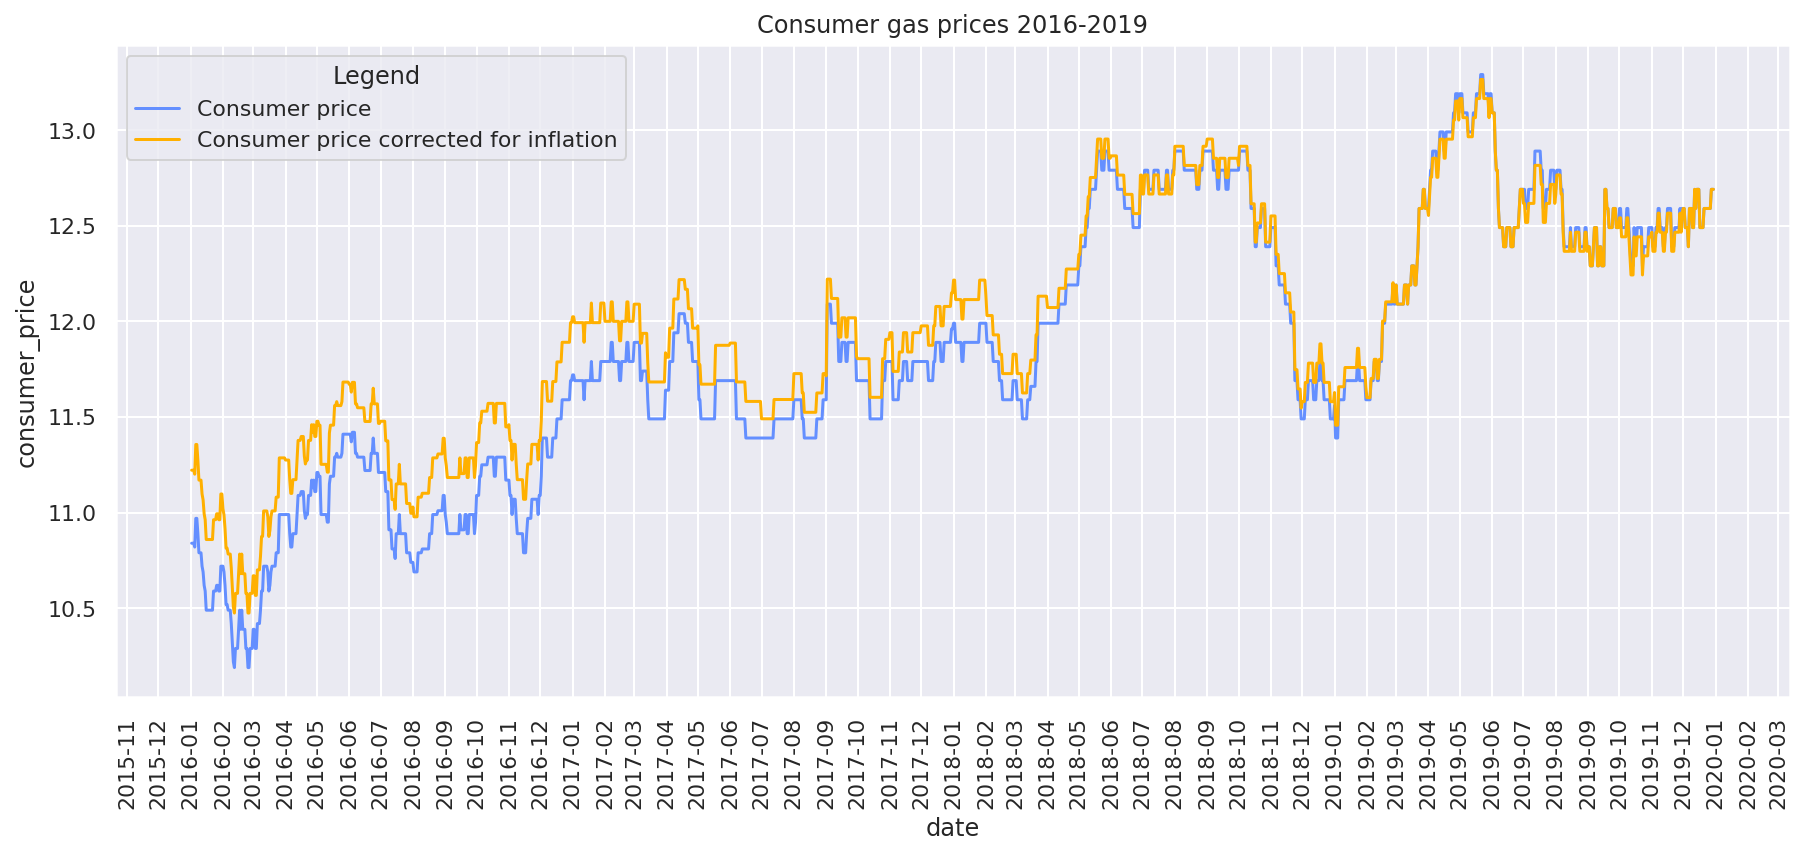

In [9]:
gas_index_path = 'index_gas.csv'
colnames = ['date', 'index']
df_gas_index = pd.read_csv(gas_index_path, names=colnames)
df_gas_index['date'] = [datetime.strptime(date, '%YM%m') for date in df_gas_index['date']]
df_gas_index.head()

gas_path = 'gas_prices.csv'
colnames = ['date', 'consumer_price', 'product_price', 'co2_fee', 'energy_fee', 'VAT']
df_gas = pd.read_csv(gas_path, names=colnames, header=0)
df_gas['consumer_price_corrected'] = np.nan
df_gas['date'] = pd.to_datetime(df_gas['date'])
df_gas = df_gas.drop(['VAT', 'energy_fee', 'product_price', 'co2_fee'], axis=1)

# Add missing dates to dataframe
df_gas = df_gas.drop_duplicates(subset=['date'])
df_gas = df_gas.set_index('date').resample('1D').ffill()
df_gas = df_gas.reset_index(level=0)

index_dict = dict(zip([str(date.year) + str(date.month) for date in df_gas_index['date']], df_gas_index['index']))

for index, row in df_gas.iterrows():
    try:
        index_val = row['consumer_price'] * df_gas_index.loc[df_gas_index['date'] == datetime.strptime('01-12-2019', '%d-%m-%Y')]['index'] /index_dict[str(row['date'].year) + str(row['date'].month)]
        df_gas.at[index, 'consumer_price_corrected'] = index_val
    except KeyError as e:
        continue

START_DATE = datetime.strptime('01-01-2016', '%d-%m-%Y')
END_DATE = datetime.strptime('31-12-2019', '%d-%m-%Y')
DATA_ERRORS_1 = pd.date_range(datetime.strptime('11-09-2017', '%d-%m-%Y'), datetime.strptime('15-11-2017', '%d-%m-%Y'))
DATA_ERRORS_2 = pd.date_range(datetime.strptime('20-05-2019', '%d-%m-%Y'), datetime.strptime('30-08-2019', '%d-%m-%Y'))
DATA_ERRORS_3 = pd.date_range(datetime.strptime('26-11-2018', '%d-%m-%Y'), datetime.strptime('02-12-2018', '%d-%m-%Y'))

normal = (df_gas['date'] > START_DATE) & (df_gas['date'] < END_DATE)
plt.figure()
sns.lineplot(data=df_gas.loc[normal], x="date", y="consumer_price", color='#648fff')
g = sns.lineplot(data=df_gas.loc[normal], x="date", y="consumer_price_corrected", color='#ffb000')
g.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=1))
plt.title("Consumer gas prices 2016-2019")
plt.legend(title='Legend', loc='upper left', labels=['Consumer price', 'Consumer price corrected for inflation'])
plt.xticks(rotation=90);

#### Removing noise from the data

Now, let's make sure that the data looks correct. We will plot the prices as a line chart, since the daily prices are closely correlated, meaning the value is not fluctuating too much. The inflation corrected price is higher and diverging more from the original price in 2016 than in 2019, indicating that the calculations should be correct. As a result of global warming and other factors, we can definitely see that the prices are increasing as time progresses, even when adjusted for inflation.

Data errors do occur. To illustrate the difference between the raw data and what the weekdays look like, we will clean up the data. The traffic counter had 3 data error periods, which we can remove. The same applies to weekends, public holidays and other outliers; these are removed as well. 

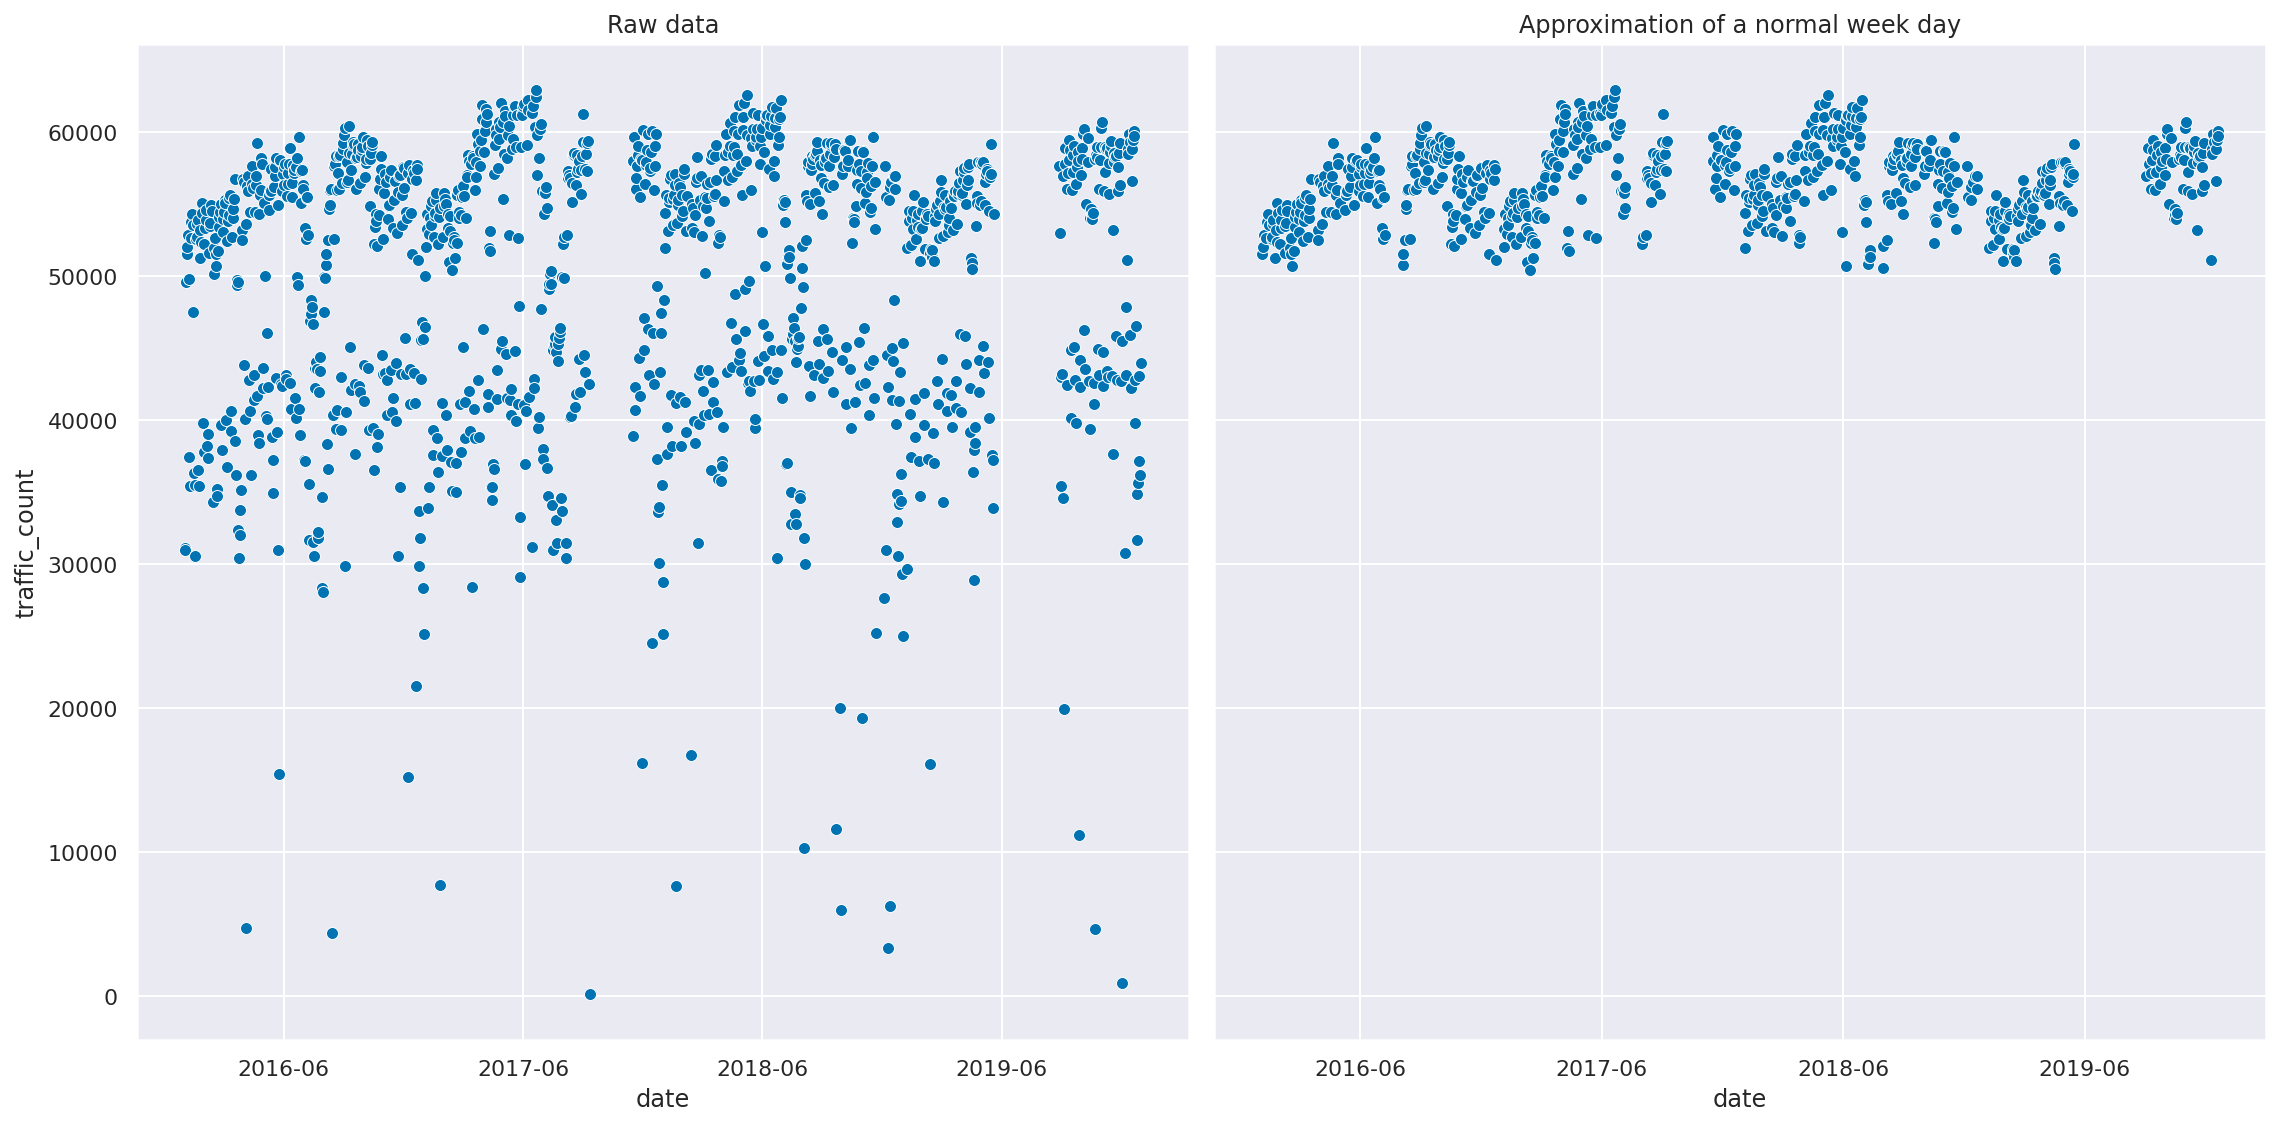

In [10]:
df_traffic_sum = df_traffic.pivot_table(index=['date', 'street', 'is_public_holiday',
                                               'is_weekend'], values='traffic_count', aggfunc='sum').reset_index()
df_traffic_sum = df_traffic_sum.dropna()
df_traffic_sum = df_traffic_sum[
    (df_traffic_sum['traffic_count'] != 0) & (df_traffic_sum['street'] == 'Mellem TSA 1 og 2')]
df_traffic_sum = df_traffic_sum.groupby([df_traffic_sum['date'].dt.date], as_index=False).agg({'date': 'first',
                                                                                               'traffic_count': 'sum',
                                                                                               'is_public_holiday': 'first',
                                                                                               'is_weekend': 'first'})
df_traffic_sum['date'] = df_traffic_sum['date'].dt.normalize()

normal = (df_traffic_sum['date'] > START_DATE) & (df_traffic_sum['date'] < END_DATE)

df_traffic_sum_pretty = df_traffic_sum[df_traffic_sum.date.dt.weekday < 5]  # Remove weekends
df_traffic_sum_pretty = df_traffic_sum_pretty[~df_traffic_sum['date'].isin(PUBLIC_HOLIDAYS)]  # Remove public holidays
df_traffic_sum_pretty = df_traffic_sum_pretty[~df_traffic_sum['date'].isin(DATA_ERRORS_1)]  # Remove data errors
df_traffic_sum_pretty = df_traffic_sum_pretty[~df_traffic_sum['date'].isin(DATA_ERRORS_2)]  # Remove data errors
df_traffic_sum_pretty = df_traffic_sum_pretty[~df_traffic_sum['date'].isin(DATA_ERRORS_3)]  # Remove data errors
q_low = df_traffic_sum_pretty["traffic_count"].quantile(0.2)
df_traffic_sum_pretty = df_traffic_sum_pretty[(df_traffic_sum["traffic_count"] > q_low)]  # Remove lower quantile

fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey='all')

g1 = sns.scatterplot(data=df_traffic_sum.loc[normal], x="date", y="traffic_count", ax=axes[0])
g1.set_title("Raw data")
g2 = sns.scatterplot(data=df_traffic_sum_pretty.loc[normal], x="date", y="traffic_count", ax=axes[1])
g2.set_title("Approximation of a normal week day")

g1.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=12))
g2.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=12))

plt.tight_layout()

When removing all the noise from the data, we can see that the traffic count is typically at its highest between May and July. This could be because people are prone to visit Copenhagen in their free time, more tourists are visiting and in general, people are more out and about when the weather is good. The machine learning algorithm should, as a result, take the month into consideration when making predictions.

# Data Analysis

## Traffic during COVID in 2020
This section will give an introductory and exploratory analysis of patterns between traffic counts in select locations in the Copenhagen area and COVID cases and hospitalizations in the same time period. The analysis will be performed on the df_tc dataframe, which was prepared in the previous section.

#### Data distributions

In order to know the general distributions of the data, we have utilized a Bokeh visualization with different tabs for the different features.

In [11]:
def bokeh_deepnote_show(plot):
    tmp_output_filename = tempfile.NamedTemporaryFile(suffix='.html').name
    output_file(tmp_output_filename)
    save(plot)

    f = open(tmp_output_filename, "r")
    display(HTML(f.read()))

#Convert your DataFrame to Bokeh ColumnDataSource
src = ColumnDataSource(df_tc.groupby(df_tc['street']).agg({'cases' : 'sum', 'hospitalizations': 'sum', 'traffic_count': 'sum',
       'traffic_count_ref': 'sum'}))

#Create an empty figure
p_traffic = figure(plot_width = 350, plot_height = 500, title = 'Traffic count 2022',
           x_axis_label = None, y_axis_label = 'Count', x_range = FactorRange(factors=df_tc['street'].unique()), background_fill_color="#fafafa") 

#Define the columns to use for each bar
bar_cols = ['traffic_count']
legends = bar_cols

#Add bars by using p.var
bar = {}
for i, col in enumerate(bar_cols):
    bar[col] = p_traffic.vbar(x='street',  top=col, source=src, width=0.5, alpha=1, muted = False, fill_color='lightblue', line_color="white")
    
p_traffic.xaxis.major_label_orientation = "vertical"

TOOLTIPS = [
    ("Total cars counted", "@traffic_count")
]

p_traffic.add_tools(HoverTool(tooltips=TOOLTIPS, renderers=[bar[bar_cols[0]]]))

# Function to create histogram plot
def make_plot(title, hist, edges, p=None):
    if p is None:
        p = figure(title=title, tools='', plot_width = 350, plot_height = 500, background_fill_color="#fafafa")

    
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color="lightblue", line_color="white", alpha=1)
    
    p.xaxis.axis_label = ''
    p.yaxis.axis_label = 'Count'
    p.grid.grid_line_color="white"
    return p

# Create histograms for traffic counts for each street
hist, edges = np.histogram(df_tc.loc[df_tc['street'] == streets[0]]['traffic_count'], density=False, bins=25)
phist1 = make_plot(streets[0], hist, edges)

hist, edges = np.histogram(df_tc.loc[df_tc['street'] == streets[1]]['traffic_count'], density=False, bins=25)
phist2 = make_plot(streets[1], hist, edges)

hist, edges = np.histogram(df_tc.loc[df_tc['street'] == streets[2]]['traffic_count'], density=False, bins=25)
phist3 = make_plot(streets[2], hist, edges)

# Create histogram for cases and hospitalizations
hist, edges = np.histogram(df_tc.loc[df_tc['street'] == streets[0]]['cases'], density=False, bins=25)
phistcases = make_plot('Cases distribution', hist, edges)

hist, edges = np.histogram(df_tc.loc[df_tc['street'] == streets[1]]['hospitalizations'], density=False, bins=25)
phisthospitalizations = make_plot('Hospitalizations distribution', hist, edges)

# Format y-axes to not use scientific numbering
phist1.yaxis.formatter.use_scientific = False
phist2.yaxis.formatter.use_scientific = False
phist3.yaxis.formatter.use_scientific = False
p_traffic.yaxis.formatter.use_scientific = False
phistcases.yaxis.formatter.use_scientific = False
phisthospitalizations.yaxis.formatter.use_scientific = False

# Layout the plots into tabs and grids
gp1 = gridplot([phist1, phist2, phist3], ncols=3, toolbar_location=None)
gp2 = gridplot([phistcases, phisthospitalizations], ncols=2, toolbar_location=None)
l1 = layout([[p_traffic]])
l2 = layout([[gp1]])
l3 = layout([[gp2]])

tab1 = Panel(child=l1,title='Traffic count')
tab2 = Panel(child=l2,title='Histogram Traffic')
tab3 = Panel(child=l3,title='Histogram COVID')
tabs = Tabs(tabs=[tab1, tab2, tab3])
curdoc().add_root(tabs)
bokeh_deepnote_show(tabs)

<!DOCTYPE html>
 
 
 
 
 
 Bokeh Plot

From the total traffic counts, it is clearly seen how 'Mellem TSA 1 og 2'/Hillerødmotorvejen sees a much higher traffic count than the other two streets. However, the three histograms show similar bimodal distributions with two peaks, likely indicating that the two rush hours of the day - morning and evening - occurs across all three streets. Looking at the histograms for COVID, both cases and hospitalizations display power-law distribution behaviour. Due to different testing capacities across 2020, we will focus on hospitalizations as the primary COVID measure in the following plots as it is a more stable metric not as dependent on the number of tests performed.

**Timeline overview plot**

Investigating a timeline plot for each street during the year of 2020 and comparing it with traffic counts from a reference year for the same street, some patterns are already visible. For all three streets, they follow a near-identical pattern with the reference year during January and February, while they all deviate significantly at the start of March – coinciding with the onset of COVID in Denmark. During the following months, the traffic seems to climb back a bit and remain at a more steady pattern. Similarly, a second decline in traffic is seen during the summer months. As this is both noticeable in the reference data and the data for 2020, it is likely due to reduced traffic during the summer vacation.

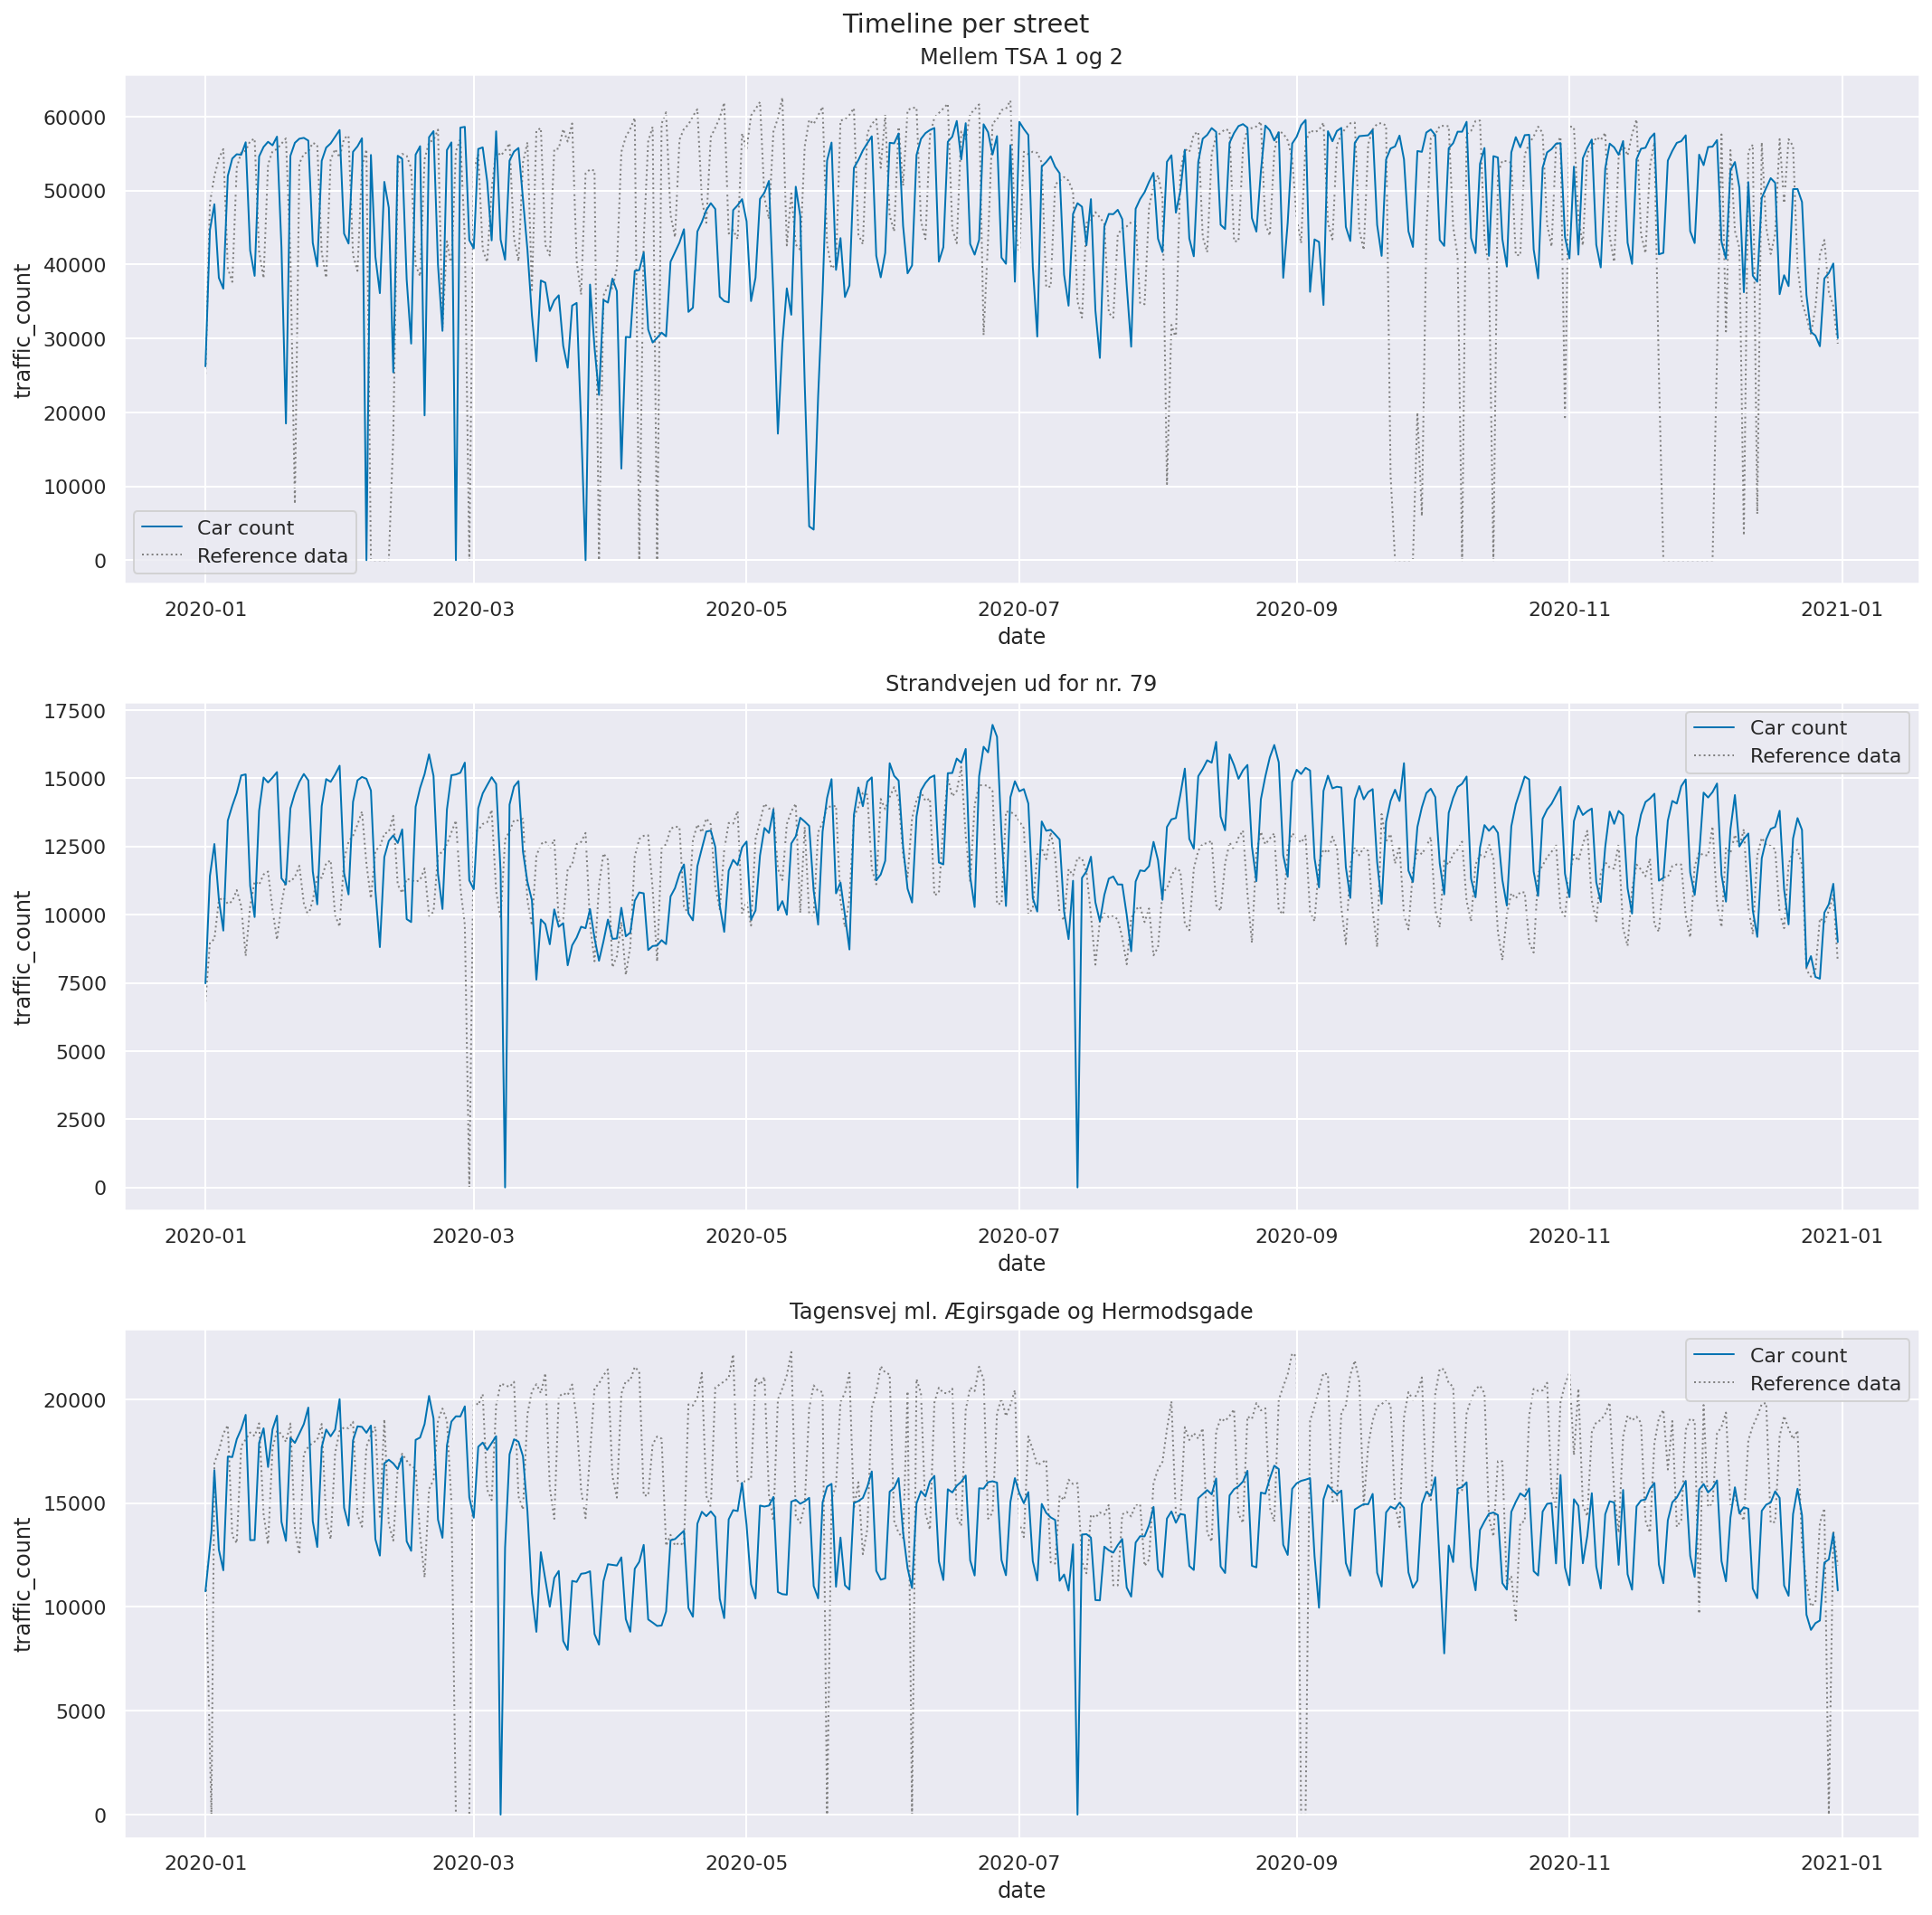

In [12]:
fig, axes = plt.subplots(3, 1, figsize=(15, 15))
        
numeric_columns = df_tc.select_dtypes(include=np.number).columns.tolist()

for i, (street, column) in enumerate(zip(streets, numeric_columns)):
    df_tc_street = df_tc.loc[df_tc['street'] == street]
    g = sns.lineplot(x=df_tc_street['date'], y=df_tc_street['traffic_count'], linewidth=1, ax=axes[i], label='Car count', zorder=1)
    g = sns.lineplot(x=df_tc_street['date'], y=df_tc_street['traffic_count_ref'], color='grey', linestyle='dotted', linewidth=1, ax=axes[i], label='Reference data', zorder=0)
    #for date, label in zip(COVID_DATES, ['First case', 'First lockdown', 'First reopening']):
    #        sns.scatterplot(x=df_tc_street['date'], y=df_tc_street.loc[df_tc_street['date'] == date]['traffic_count'], s=200, ax=axes[i], zorder=2, label=label)
        
    g.set_title(street)

fig.suptitle('Timeline per street')
plt.tight_layout()

**Timeline for traffic and COVID combined**

To further analyse the relation between COVID and traffic counts, the previous plots will be overlayed with COVID-related data. The number of hospitalizations on a given date is shown, as well as important dates marking events during the initial part of the COVID response in 2020.

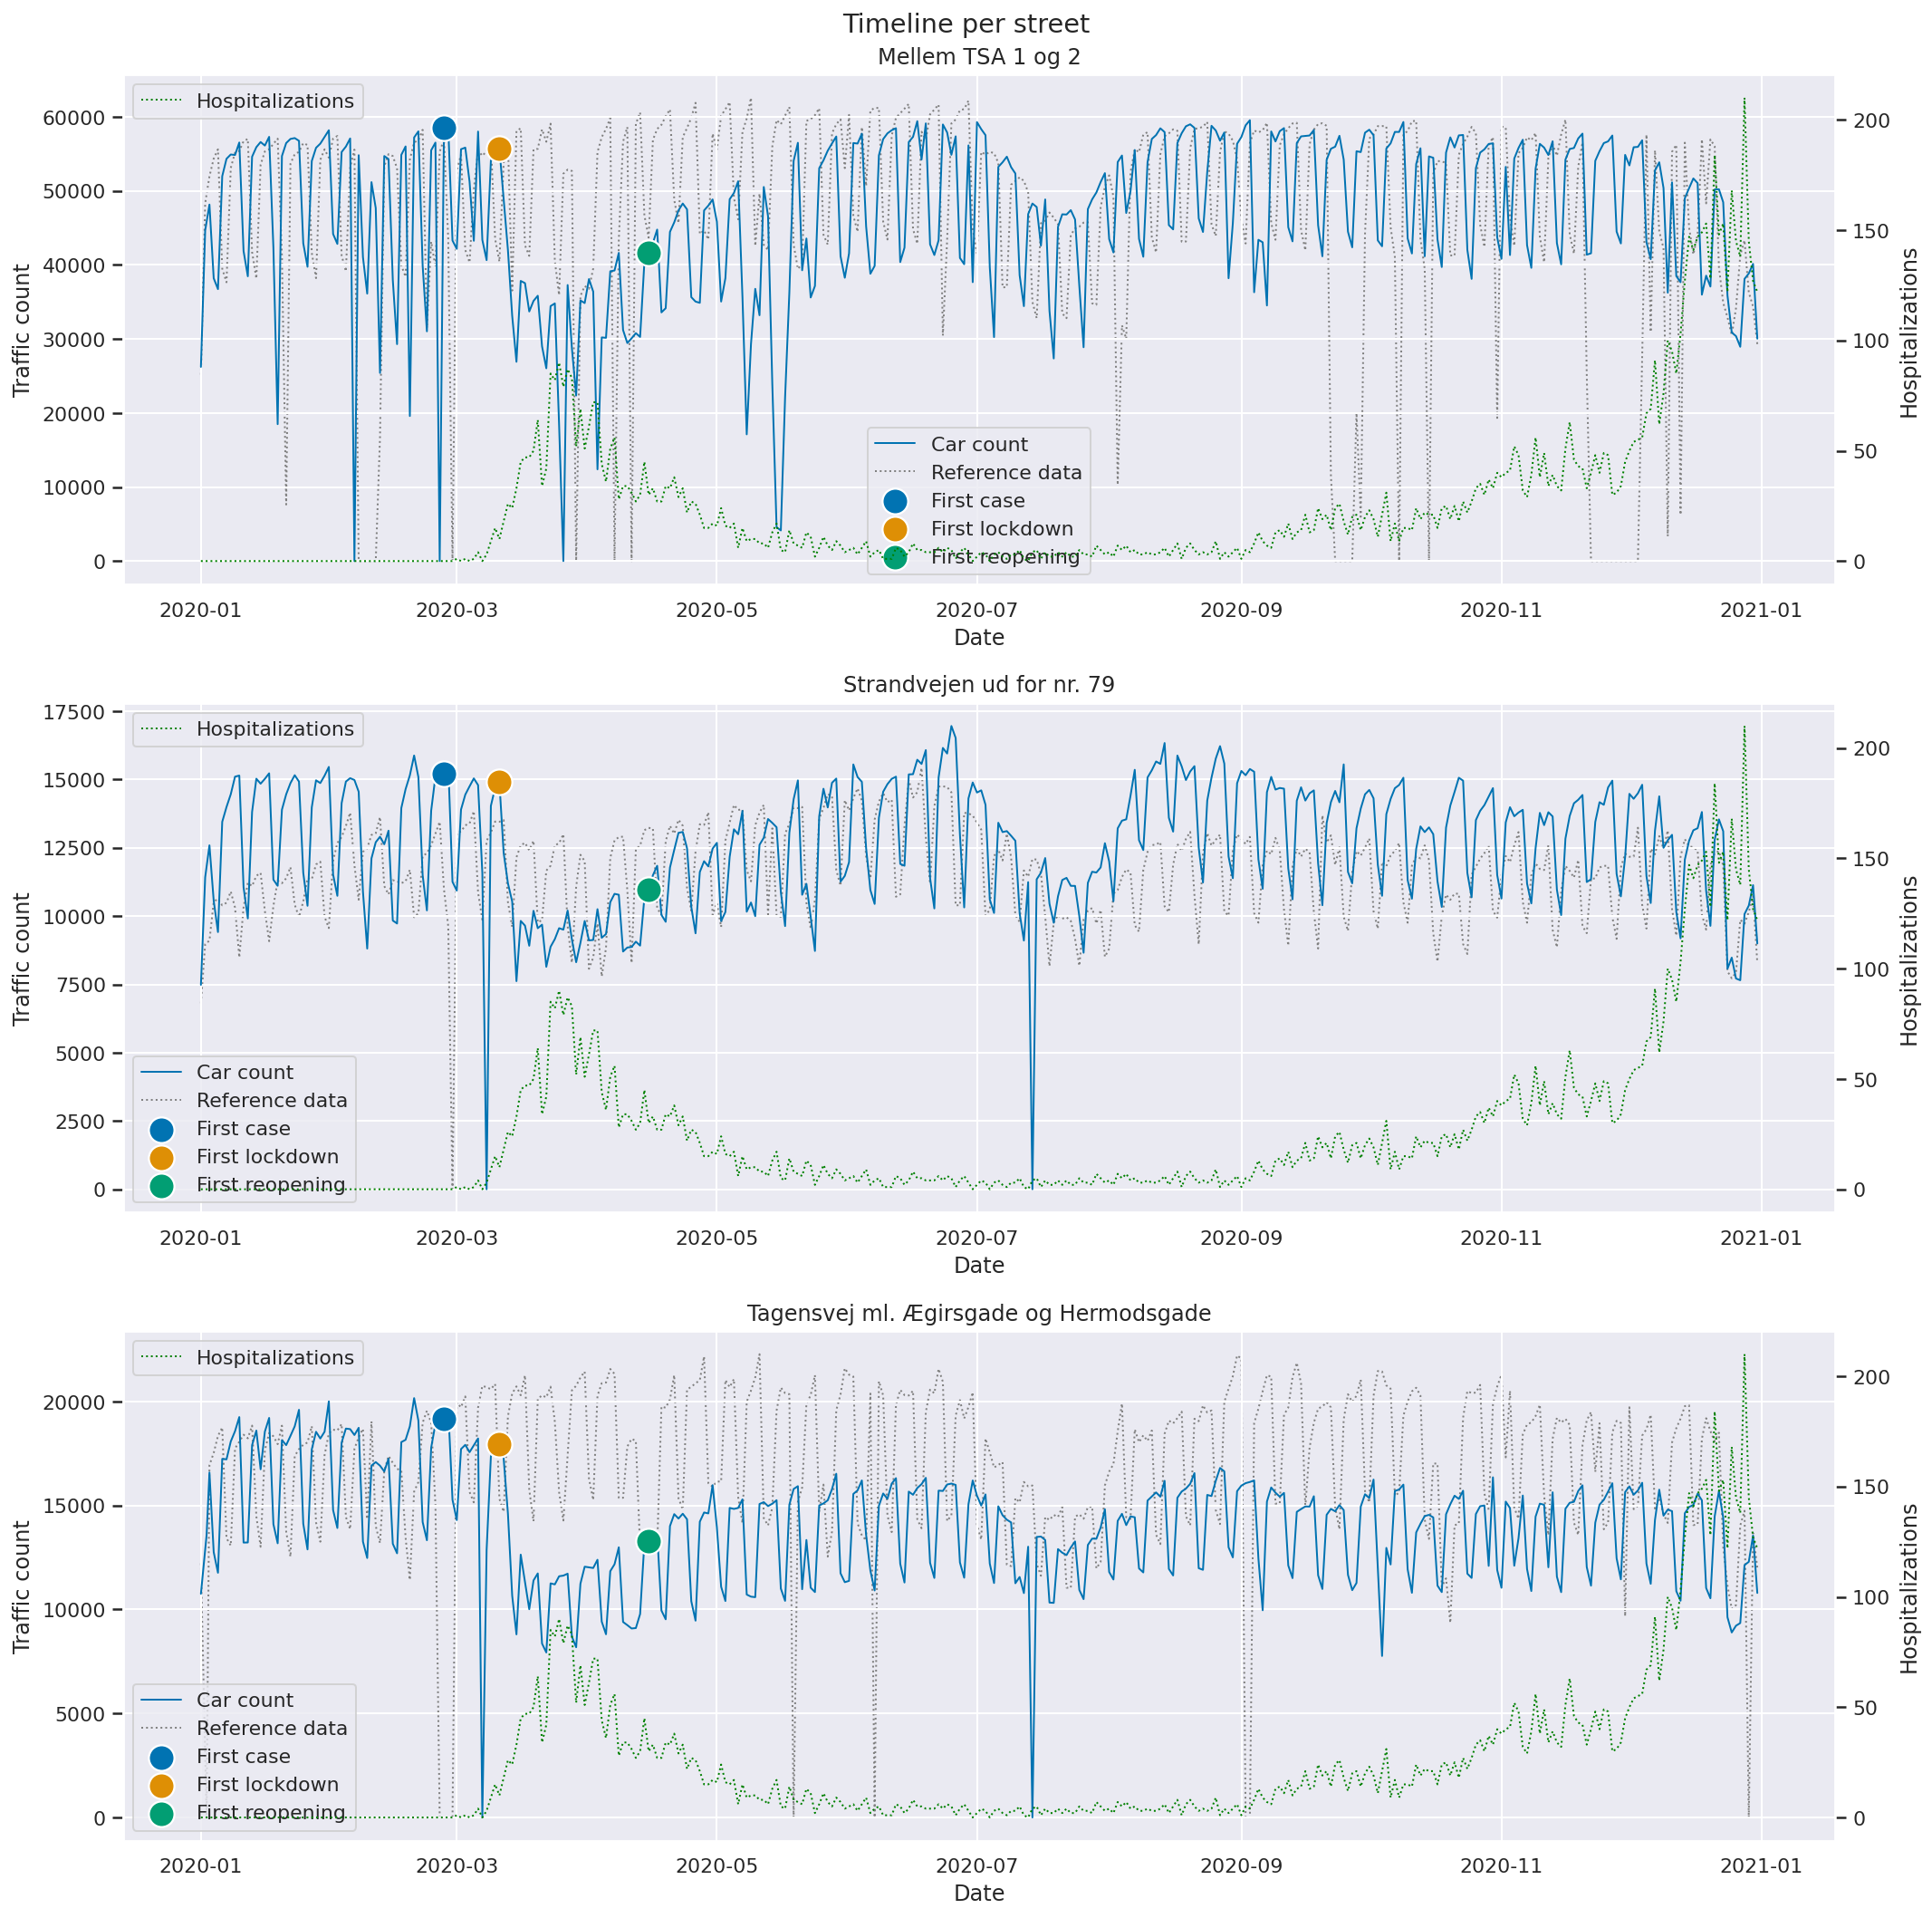

In [13]:
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

for i, street in enumerate(streets):
    df_tc_street = df_tc.loc[df_tc['street'] == street]
    g = sns.lineplot(x=df_tc_street['date'], y=df_tc_street['traffic_count'], linewidth=1, ax=axes[i], label='Car count', zorder=1)
    g = sns.lineplot(x=df_tc_street['date'], y=df_tc_street['traffic_count_ref'], color='grey', linestyle='dotted', linewidth=1, ax=axes[i], label='Reference data', zorder=0)
    
    ax2 = axes[i].twinx()
    ax2.grid(False)
    g2 = sns.lineplot(x=df_tc_street['date'], y=df_tc_street['hospitalizations'], linestyle='dotted', linewidth=1, axes=ax2, color='green', label='Hospitalizations')
    
    for date, label in zip(COVID_DATES, ['First case', 'First lockdown', 'First reopening']):
            sns.scatterplot(x=df_tc_street['date'], y=df_tc_street.loc[df_tc_street['date'] == date]['traffic_count'], s=200, ax=axes[i], zorder=2, label=label)
    
    g.set_title(street)
    g.set_xlabel('Date')
    g.set_ylabel('Traffic count')
    g2.set_ylabel('Hospitalizations')

fig.suptitle('Timeline per street')
plt.tight_layout()

With overlaid COVID data, the apparent relation between important events and hospitalizations and car traffic is verified. From the first verified case in Denmark until the first lockdown, a slight decrease in traffic is observed – society is slowly acting on restrictions being announced in other countries as well as the unknown future the COVID pandemic might bring. When the first lockdown happened, a very drastic drop in traffic occurs across all three streets. A delay between hospitalizations and traffic reduction is seen, as the restrictions were announced based on increasing infections in society and hospitalizations occur 3-10 days after an infection has been reported.

#### Hourly plots during COVID vs before
An interesting aspect to look at would be the hourly changes in traffic during the initial part of COVID lockdowns where hospitalizations were high, and knowledge about consequences low - thus resulting in a harsh lockdown. As just shown, a clear difference in traffic counts between 2020 and the reference data exists during this period when viewed on a daily basis. But is there a change in patterns if viewed on an hourly basis?

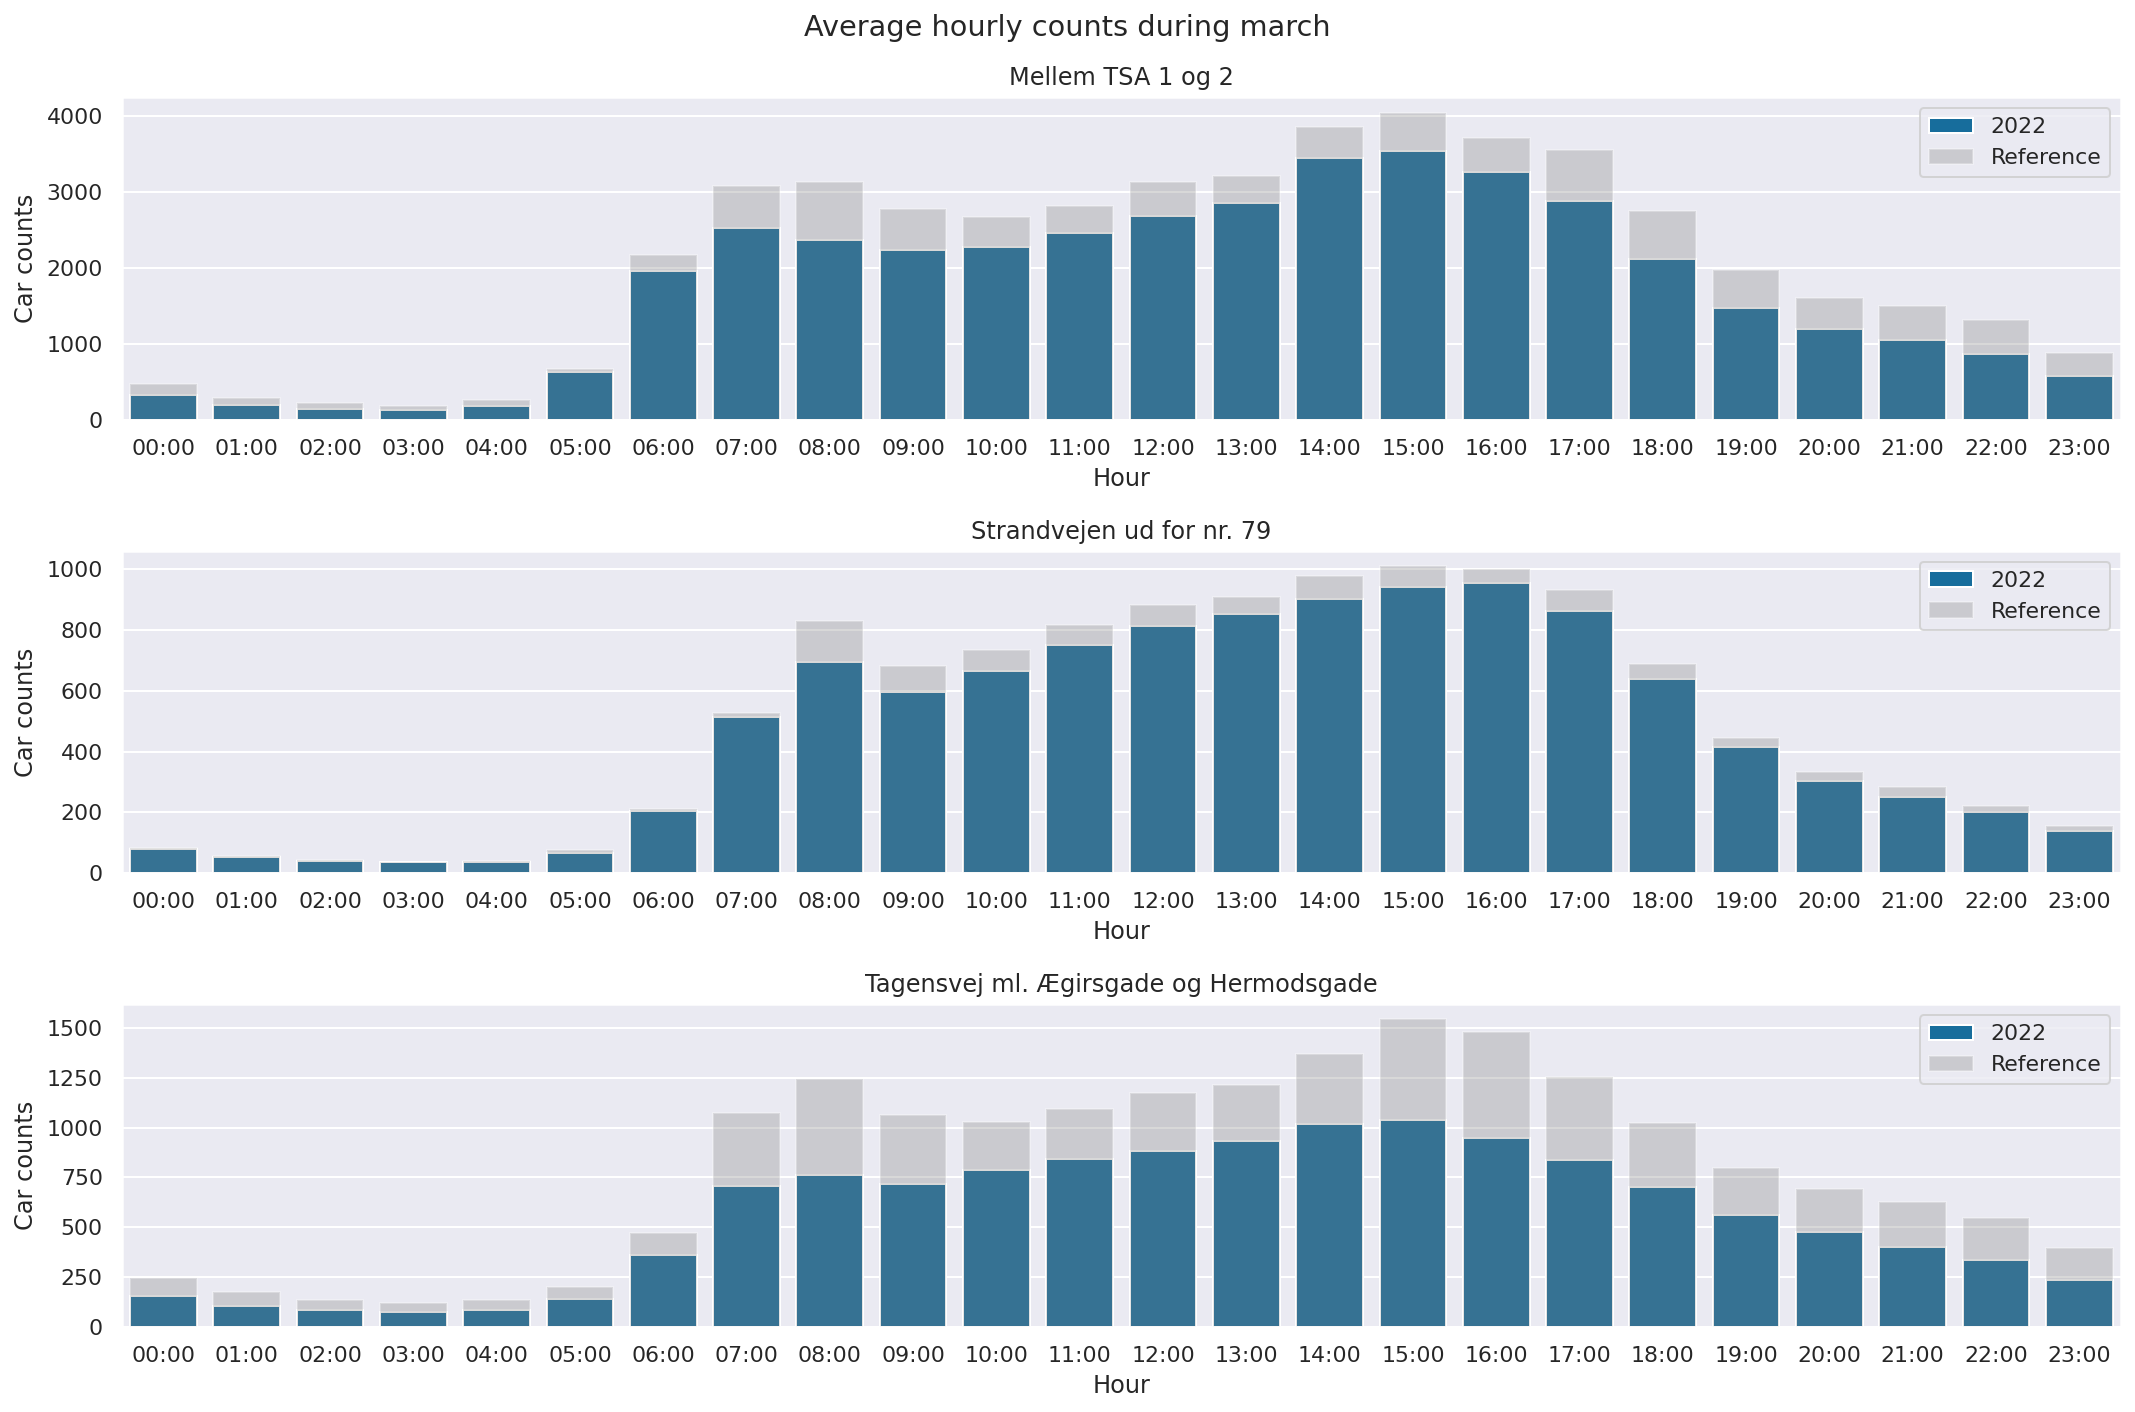

In [14]:
# Plots of hourly counts averaged over the month of march
df_march = df_traffic[df_traffic['date'].map(lambda x : (x.year == 2020) & (x.month == 3))]
df_march['hour'] = df_march['date'].dt.strftime('%H:%M')
df_hour = df_march.groupby([df_march['date'].dt.hour, df_march['street']], as_index=False).agg({'hour': 'first', 'traffic_count': 'mean'})

df_march_ref = df_ref[df_ref['date'].map(lambda x : x.month == 3)]
df_march_ref['hour'] = df_march_ref['date'].dt.strftime('%H:%M')
df_hour_ref = df_march_ref.groupby([df_march_ref['date'].dt.hour, df_march_ref['street']], as_index=False).agg({'hour': 'first', 'traffic_count': 'mean'})

fig, axes = plt.subplots(3, 1, figsize=(15,10))

for i, street in enumerate(streets):
    df_hour_street = df_hour.loc[df_hour['street'] == street]
    df_hour_street_ref = df_hour_ref.loc[df_hour_ref['street'] == street]
    g = sns.barplot(data=df_hour_street, x='hour', y='traffic_count', color=sns.color_palette('colorblind')[0], alpha=1, linewidth=1, ax=axes[i], label='2022')
    g = sns.barplot(data=df_hour_street_ref, x='hour', y='traffic_count', color='grey', alpha=0.3, linewidth=1, ax=axes[i], label='Reference')
    g.set_title(street) 
    g.set_xlabel('Hour')
    g.set_ylabel('Car counts')
    g.legend()
    g.ticklabel_format(style='plain', axis='y')

fig.suptitle('Average hourly counts during march')
plt.tight_layout()

It is clear how for each of the three roads, the traffic counts have decreased during the daytime - especially at Tagensvej a significant difference is observed. Not only is the decrease large, but the rush hour peak in the morning is not distinct from the following hours and just follows the general increase in traffic until the peak at 15:00. Strandvejen experienced the least difference in traffic of the three – with a slight decrease during daytime and no significant changes from 18:00 until 07:00 in the morning. The general small decrease seen at Strandvejen may indicate that little commuter traffic occurs, as this type of traffic were reduced the most during COVID due to work-from-home policies.

## Predicting traffic with gas prices

The war in Ukraine increased the global gas prices by a huge factor, which got us wondering if the gas prices might have had an impact on traffic in Copenhagen. We just read in the previous section that Covid-19 had a huge impact on traffic, and we therefore chose to limit our data from 1/1-2016 to 31/12-2019. Since the traffic data is full of data errors, we had to limit our focus to merely one traffic counter. The traffic counter is placed on "Hillerødmotorvejen" and DRD calls it "Mellem TSA 1 og 2", this can be seen on the map with all the traffic counters. One might argue that this will not give the full picture of the traffic. However, this is a major access point for Copenhagen, topping at around 60,000 cars on a week day. 

We imagine there will be a negative correlation between gas prices and traffic count, but the rising number of cars in and around Copenhagen is steadily increasing. 

### Setup

We combine and optimize our traffic data with the corrected gas prices as follows:
- Remove the data errors from the traffic data
- Remove the lower quantile from the traffic data
- Merge the traffic data with gas prices
- Encode the months as categories, since we saw there is more traffic in some months, discussed in basic stats.

In [22]:
df_traffic_sum_no_outliers = df_traffic_sum
df_traffic_sum_no_outliers = df_traffic_sum_no_outliers[~df_traffic_sum['date'].isin(DATA_ERRORS_1)] # Remove data errors
df_traffic_sum_no_outliers = df_traffic_sum_no_outliers[~df_traffic_sum['date'].isin(DATA_ERRORS_2)] # Remove data errors
df_traffic_sum_no_outliers = df_traffic_sum_no_outliers[~df_traffic_sum['date'].isin(DATA_ERRORS_3)] # Remove data errors
q_low = df_traffic_sum_no_outliers["traffic_count"].quantile(0.2) # Remove lower quantile
df_traffic_sum_no_outliers = df_traffic_sum_no_outliers[(df_traffic_sum_no_outliers["traffic_count"] > q_low)]

df_traffic_gas = pd.merge(df_traffic_sum_no_outliers.loc[normal], df_gas, on="date")
df_traffic_gas = df_traffic_gas.loc[:, ["date", "traffic_count", "is_weekend", "is_public_holiday","consumer_price_corrected"]]
df_traffic_gas['month'] = df_traffic_gas['date'].dt.strftime('%m')
one_hot = pd.get_dummies(df_traffic_gas['month'])
# Join the encoded dataframes
df_traffic_gas = df_traffic_gas.join(one_hot)
# Drop columns as it is now encoded
df_traffic_gas.index = df_traffic_gas['date']
df_traffic_gas = df_traffic_gas.drop('date',axis = 1)
df_traffic_gas = df_traffic_gas.drop('month',axis = 1)
df_traffic_gas.describe().iloc[:, :2]

traffic_count 
 consumer_price_corrected 
 
 
 
 
 count 
 1005.000000 
 1005.000000 
 
 
 mean 
 53161.347264 
 11.970385 
 
 
 std 
 6062.497687 
 0.589052 
 
 
 min 
 40636.000000 
 10.475035 
 
 
 25% 
 49082.000000 
 11.571125 
 
 
 50% 
 55168.000000 
 11.964408 
 
 
 75% 
 57788.000000 
 12.465771 
 
 
 max 
 62950.000000 
 13.164413

When looking at the basic stats, we see that we have 1005 dates to train our model, it is not a lot, but should be sufficient. Since we are building a linear model, we should have enough to gain insight. We would like to have a model that has a mean absolute error on a maximum of half the standard deviation. To be certain that it is not purely guesses.

We set our target value for the models to predict ```traffic_count```, and the rest of the dataframe are features. Afterwards, a split is made to separate test/train data and lastly prepare a result dataframe, in order to compare our results.

To further enhance the model, we could implement K-fold cross validation on our data.

In [23]:
# X is predictors, y is target
target = 'traffic_count'
features = [col for col in df_traffic_gas.columns if col != target]
X = df_traffic_gas[features]
y = df_traffic_gas[target]

# Split according to a 70%/30% train/test policy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

results_df = pd.DataFrame({'actuals': y_test, 'is_weekend': X_test['is_weekend'], 'is_public_holiday': X_test['is_public_holiday']})

### Baseline model

Let us set up a primitive model, it fits to mean of all y values. This model is not very good, how ever gives a good indication of how much better our model is compared to a naive guess.

The model is constructed with a fit and predict function:

In [25]:
class Baseline:
    def __init__(self):
        self.mean = None

    def fit(self, y):
        # Fits to the mean of all y-values
        self.mean = np.mean(y)
    
    def predict(self, X):
        # Check if X is a list of features, or just one feature
        if isinstance(X, list):
            return [self.mean] * len(X[0])
        else:
            return [self.mean] * len(X)

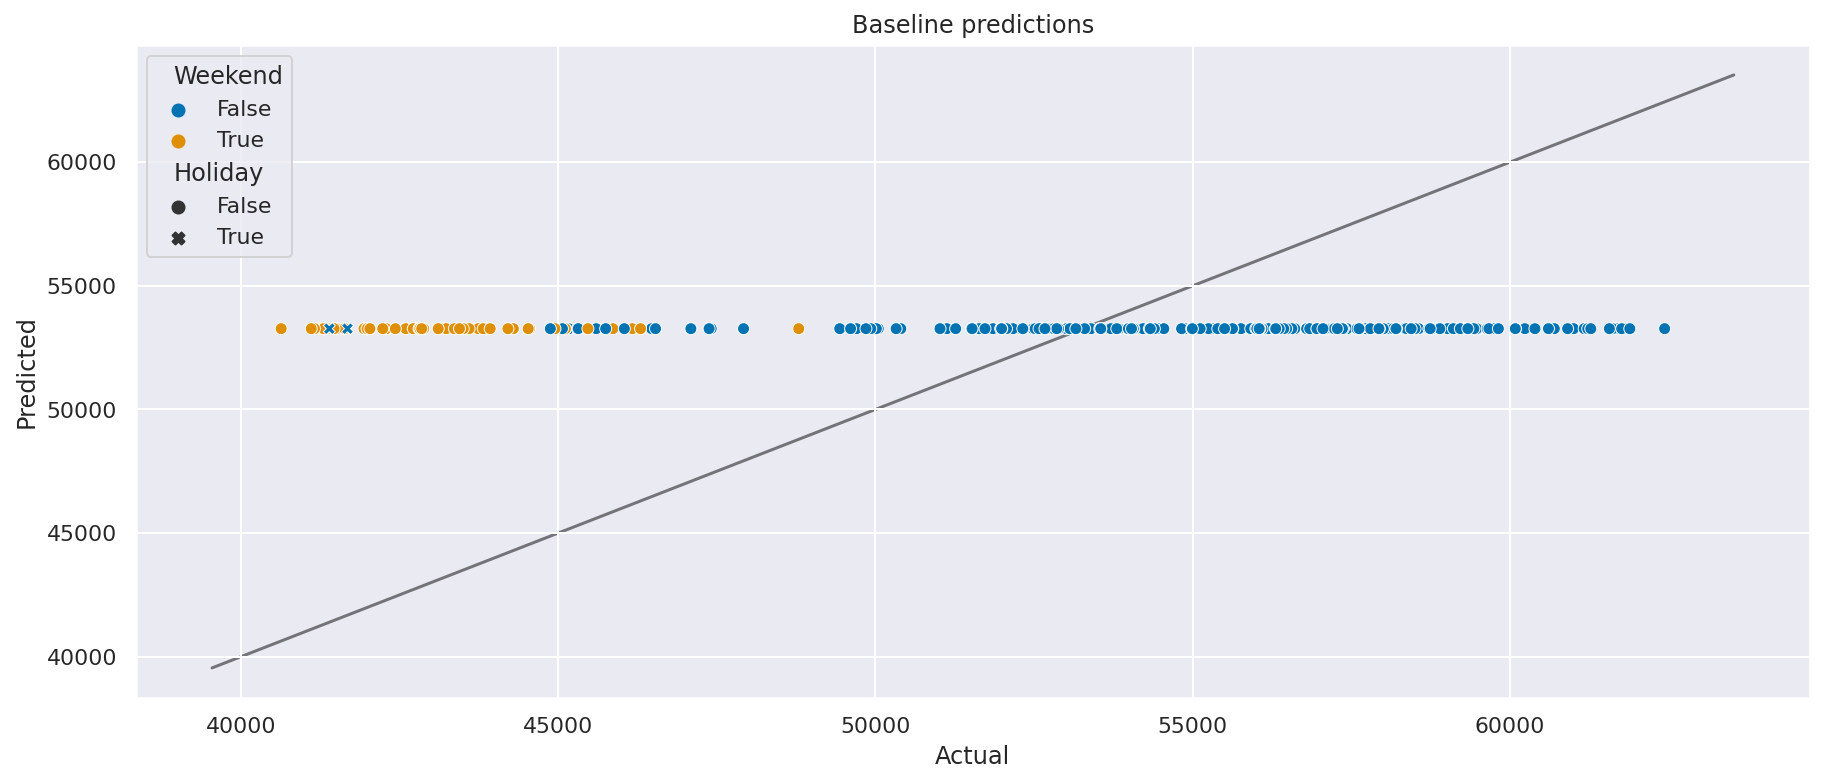

In [26]:
baseline = Baseline()
baseline.fit(y_train) # Train the model

baseline_y_pred = baseline.predict(X_test) # Predict values
results_df["baseline"] = baseline_y_pred # Store predicted values

df_metrics = pd.DataFrame({
    "metric" : [],"value"  : []
})
df_metrics.loc[len(df_metrics.index)] = ["Mean squared error", "{:.2f}".format(metrics.mean_squared_error(y_test, baseline_y_pred))]
df_metrics.loc[len(df_metrics.index)] = ["Coefficient of determination", "{:.2f}".format(metrics.r2_score(y_test, baseline_y_pred))]
df_metrics.loc[len(df_metrics.index)] = ["Mean Absolute Error", "{:.2f}".format(metrics.mean_absolute_error(y_test, baseline_y_pred))]
df_metrics.loc[len(df_metrics.index)] = ["Root Mean Squared Error", "{:.2f}".format(np.sqrt(metrics.mean_squared_error(y_test, baseline_y_pred)))]

df_temp = pd.DataFrame({'Actual': y_test, 'Predicted': baseline_y_pred, 'Weekend': X_test['is_weekend'], 'Holiday': X_test['is_public_holiday']})
ax = sns.scatterplot(data=df_temp, x='Actual', y='Predicted', hue='Weekend', style='Holiday');
ax.set_title("Baseline predictions")

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
sns.lineplot(lims, lims, alpha=0.50, zorder=0, color='black');

Of to a somewhat of a start, the x-values have no impact in this model, forcing it to guess the mean value. To have perfect guesses, we would like the point to align with the black line. This graph did also show that weekends and public holidays have fever people on the road, since only a few people are working. Let us dive into some more details about this model with some metrics. 

In [27]:
df_metrics.head(5)

metric 
 value 
 
 
 
 
 0 
 Mean squared error 
 36544586.29 
 
 
 1 
 Coefficient of determination 
 -0.00 
 
 
 2 
 Mean Absolute Error 
 4958.79 
 
 
 3 
 Root Mean Squared Error 
 6045.21

The first thing to notice is the coefficient of determination, as stated before we would like the points to be on the line. If this were the case, this coefficient should have been close to 1, but in this case it is 0 indicating no correlation. The mean absolute error measures the average of the absolute distance between the predicted value $\hat{y}_i$ and the true value $y_i$. The root mean squared error is almost the same although the average of the absolute distance squared, meaning it can detect outliers better, e.g. when choosing the best model. 

We would like this value to be below half of the standard deviation of the traffic count, but that is not the case. Let us try to predict using linear regression. 

### Linear Regression model

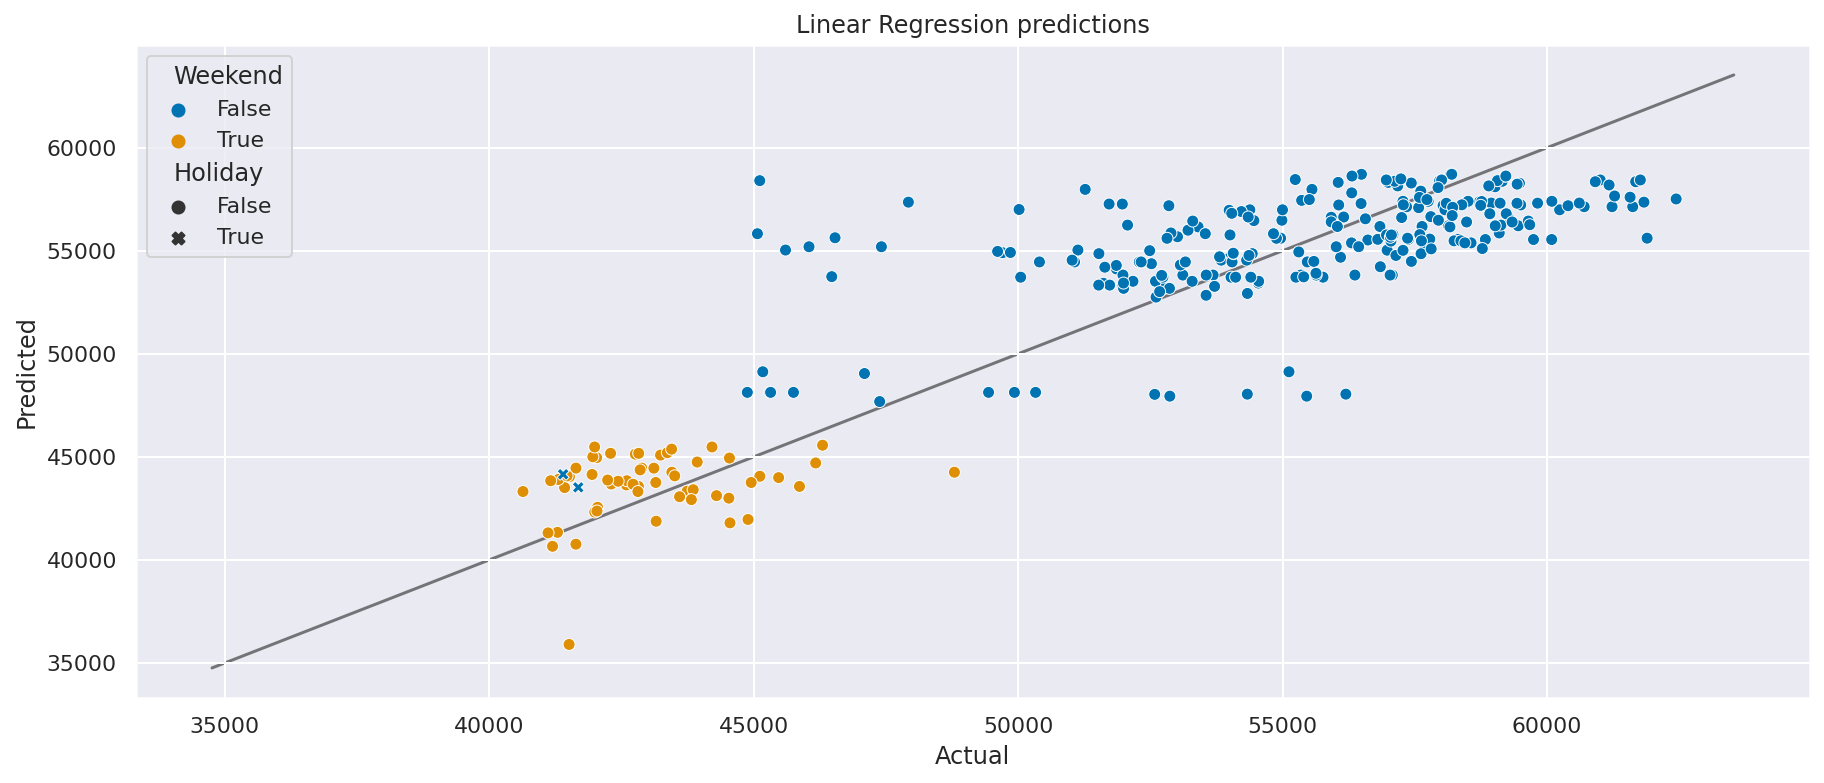

In [30]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train) # Train the model

lin_y_pred = lin_reg.predict(X_test) # Predict values
results_df["linear_regression"] = lin_y_pred

df_metrics = pd.DataFrame({
    "metric" : [],"value" : []
})
df_metrics.loc[len(df_metrics.index)] = ["Mean squared error", "{:.2f}".format(metrics.mean_squared_error(y_test, lin_y_pred))]
df_metrics.loc[len(df_metrics.index)] = ["Coefficient of determination", "{:.2f}".format(metrics.r2_score(y_test, lin_y_pred))]
df_metrics.loc[len(df_metrics.index)] = ["Mean Absolute Error", "{:.2f}".format(metrics.mean_absolute_error(y_test, lin_y_pred))]
df_metrics.loc[len(df_metrics.index)] = ["Root Mean Squared Error", "{:.2f}".format(np.sqrt(metrics.mean_squared_error(y_test, lin_y_pred)))]

df_temp = pd.DataFrame({'Actual': y_test, 'Predicted': lin_y_pred, 'Weekend': X_test['is_weekend'], 'Holiday': X_test['is_public_holiday']})
ax = sns.scatterplot(data=df_temp, x='Actual', y='Predicted', hue='Weekend', style='Holiday');
ax.set_title("Linear Regression predictions")

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
sns.lineplot(lims, lims, alpha=0.50, zorder=0, color='black');

The linear regression model looks much more promising than the baseline model. The x-values now have an impact on the y-values. The points are aligning a lot with the black line, implying a good model. This graph also showed that weekends and public holidays have fever people on the road; only now the predictions are close to the actual values. Let us explore some more details about this model with some metrics. 

In [31]:
df_metrics.head(6)

metric 
 value 
 
 
 
 
 0 
 Mean squared error 
 8297299.22 
 
 
 1 
 Coefficient of determination 
 0.77 
 
 
 2 
 Mean Absolute Error 
 2176.50 
 
 
 3 
 Root Mean Squared Error 
 2880.50

Let us start with the coefficient of determination, now the value is closer to 1, implying that the predictions are closer to the actual values. We can further confirm this by looking at the mean absolute error, this is around 2200, well below half the standard deviation of the traffic count. Both of these metrics tell us that we have something better than a baseline.

For the last model to predict, we will use a neural network. 

### Artificial neural network

This model is the "Multi-layer Perceptron regressor" from sklearn; it uses the activation function 'relu', which is a rectified linear unit function, that returns $f(x) = \mathrm{max}(0, x)$. The solver for weight optimization is limited-memory BFGS (L-BFGS) which is an optimizer in the family of quasi-Newton methods. The details for these are way too complex to explain in this context, but rest assured that this combination gave the best model.

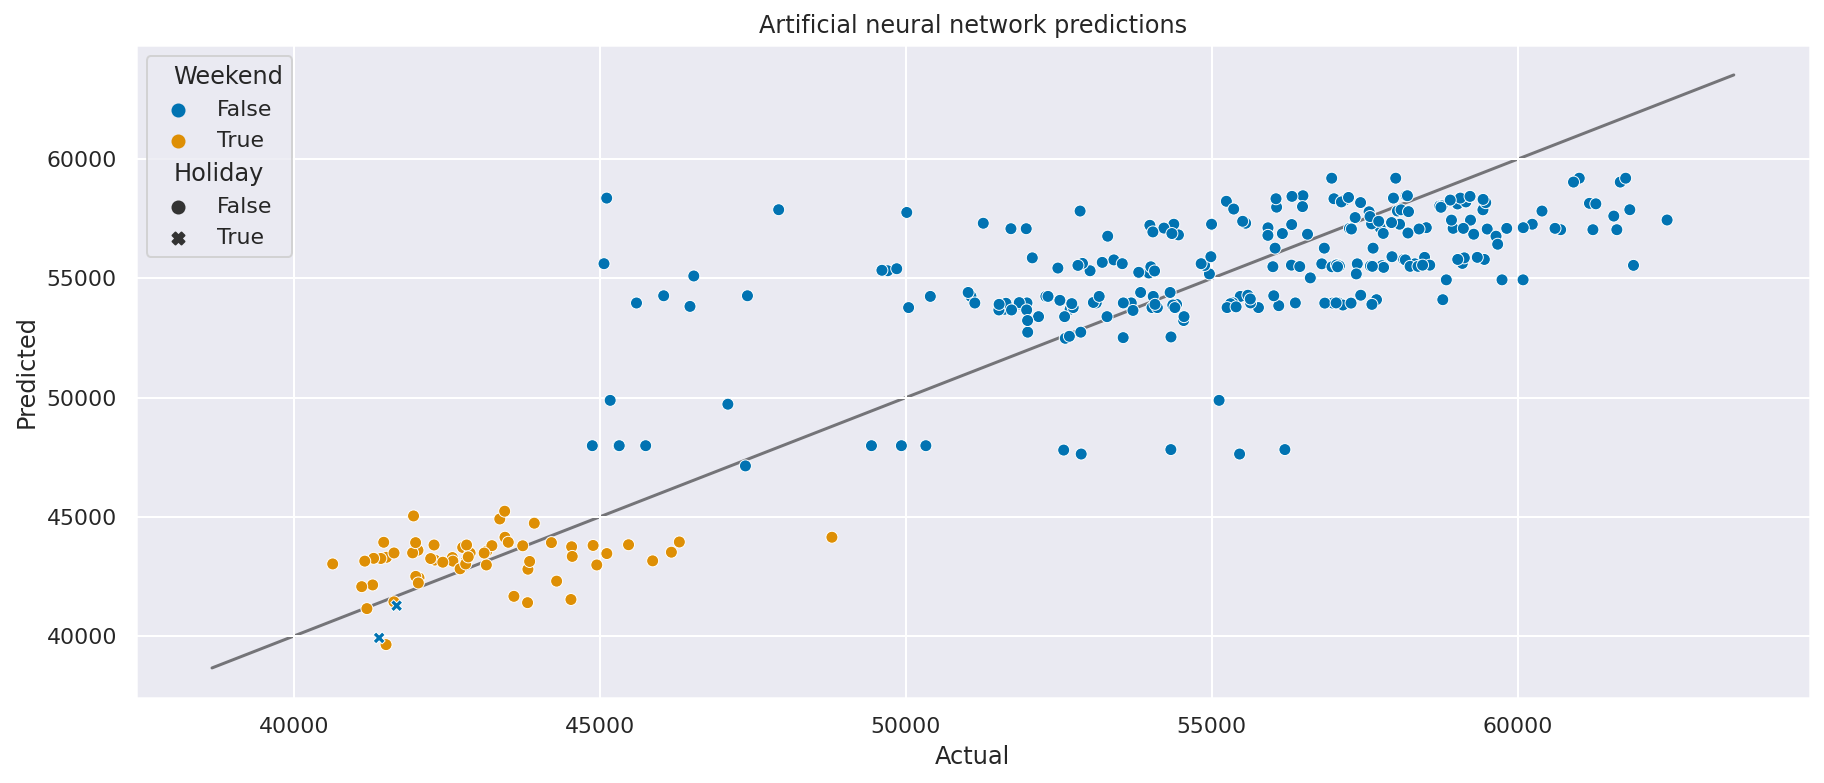

In [32]:
ann_reg = MLPRegressor(max_iter = 500, activation='relu', solver='lbfgs') # Neural network model for regression
ann_reg.fit(X_train, y_train)

ann_y_pred = ann_reg.predict(X_test) # Predict values
results_df["ann"] = ann_y_pred

df_metrics = pd.DataFrame({
    "metric" : [],"value"  : []
})
df_metrics.loc[len(df_metrics.index)] = ["Mean squared error", "{:.2f}".format(metrics.mean_squared_error(y_test, ann_y_pred))]
df_metrics.loc[len(df_metrics.index)] = ["Coefficient of determination", "{:.2f}".format(metrics.r2_score(y_test, ann_y_pred))]
df_metrics.loc[len(df_metrics.index)] = ["Mean Absolute Error", "{:.2f}".format(metrics.mean_absolute_error(y_test, ann_y_pred))]
df_metrics.loc[len(df_metrics.index)] = ["Root Mean Squared Error", "{:.2f}".format(np.sqrt(metrics.mean_squared_error(y_test, ann_y_pred)))]

df_temp = pd.DataFrame({'Actual': y_test, 'Predicted': ann_y_pred, 'Weekend': X_test['is_weekend'], 'Holiday': X_test['is_public_holiday']})
ax = sns.scatterplot(data=df_temp, x='Actual', y='Predicted', hue='Weekend', style='Holiday');
ax.set_title("Artificial neural network predictions")
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
sns.lineplot(lims, lims, alpha=0.50, zorder=0, color='black');

The artificial neural network model looks just as promising as the linear regression model. The points are aligning a lot with the black line, implying a good model. Again, we see that weekends and public holidays have fever people on the road. There are still some outliers, but this needs to be addressed from another perspective, where the dates are plotted as well.

In [33]:
df_metrics.head(6)

metric 
 value 
 
 
 
 
 0 
 Mean squared error 
 8066303.16 
 
 
 1 
 Coefficient of determination 
 0.78 
 
 
 2 
 Mean Absolute Error 
 2118.52 
 
 
 3 
 Root Mean Squared Error 
 2840.12

These metrics are pretty similar to the linear regression model, although the coefficient of determination is closer to 1, and the errors are smaller, indicating a slight increase in performance. To figure out if there is a significant difference, a t-test should be conducted. 

### Model summary

We would like to address the problem with some of the outliers, and actually see how the models are predicting when given the test data. All of the results are gathered in ```results_df``` and can therefore easily be plotted.

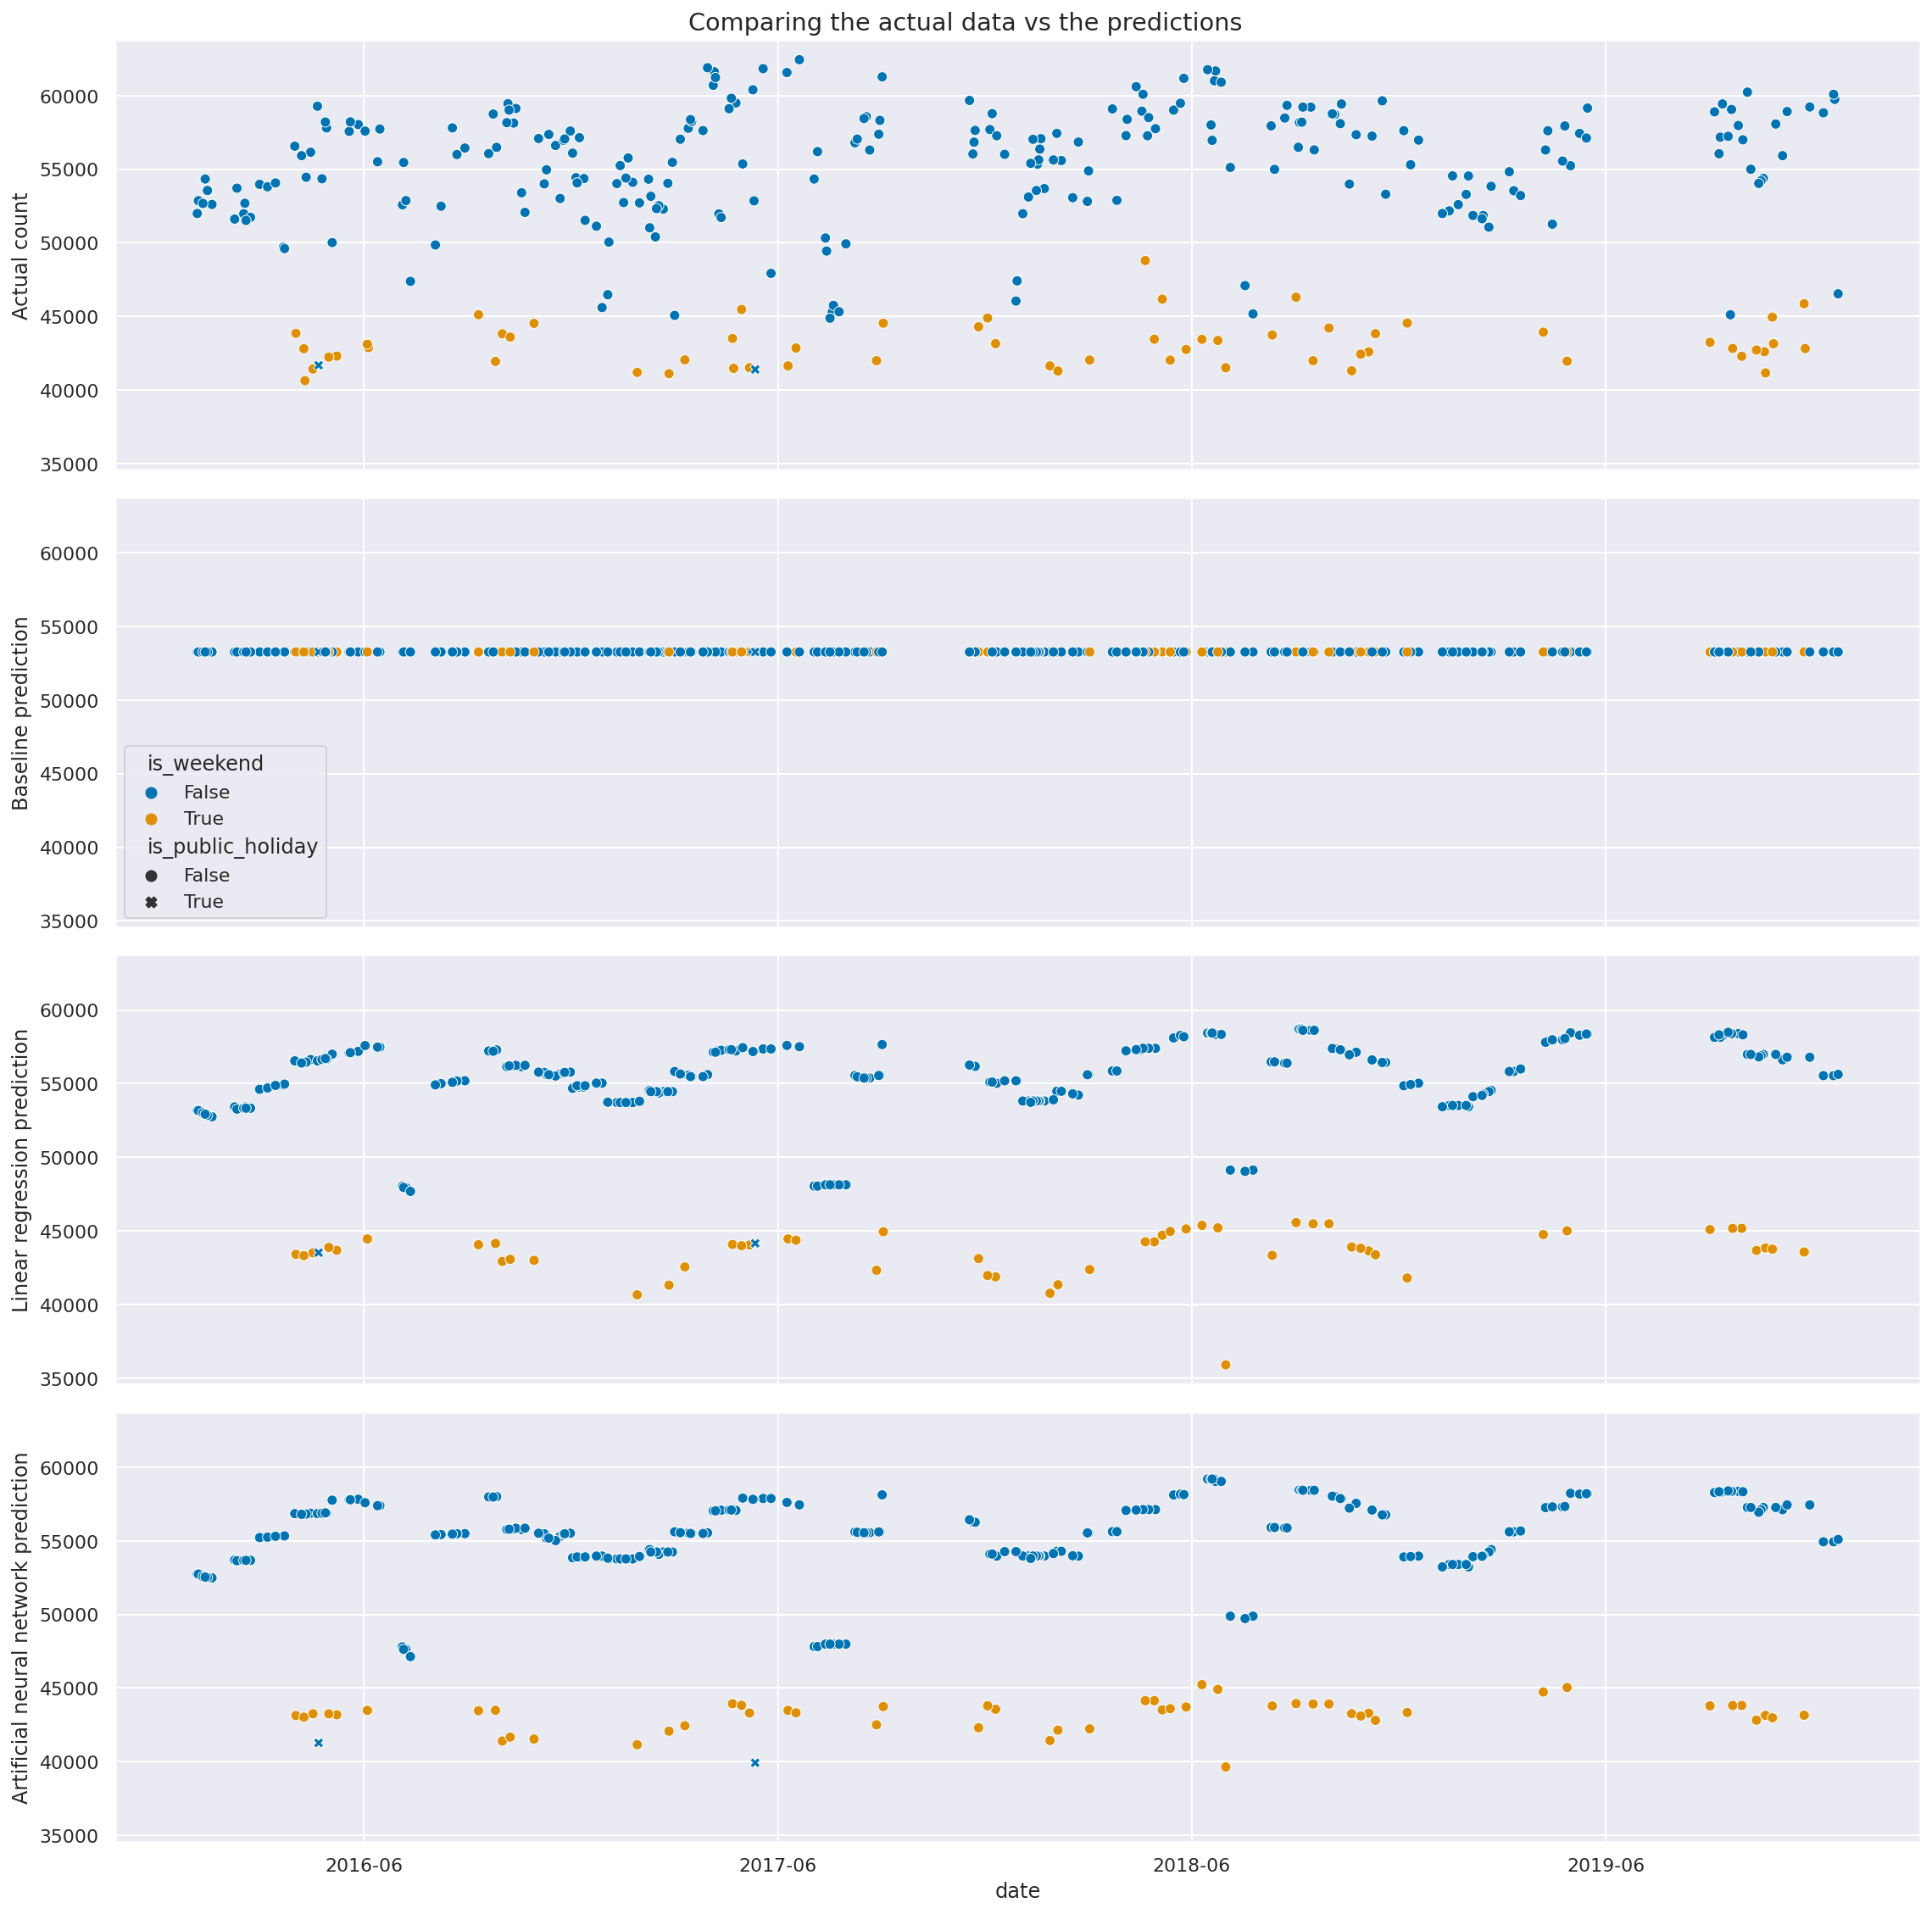

In [34]:
fig, axes = plt.subplots(4,1,figsize=(16,16), sharey='all', sharex='all')
plt.suptitle("Comparing the actual data vs the predictions")
g1 = sns.scatterplot(data=results_df, x='date', y='actuals', ax=axes[0], hue='is_weekend', style='is_public_holiday', legend=False)
g1.set_ylabel('Actual count')
g2 = sns.scatterplot(data=results_df, x='date', y='baseline', ax=axes[1], hue='is_weekend', style='is_public_holiday')
g2.set_ylabel('Baseline prediction')
g3 = sns.scatterplot(data=results_df, x='date', y='linear_regression', ax=axes[2], hue='is_weekend', style='is_public_holiday', legend=False)
g3.set_ylabel('Linear regression prediction')
g4 = sns.scatterplot(data=results_df, x='date', y='ann', ax=axes[3], hue='is_weekend', style='is_public_holiday', legend=False)
g4.set_ylabel('Artificial neural network prediction')

g4.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=12))

plt.tight_layout()

When plotting all of the predictions along side the actual count, we can see that the last two models are almost the same. The blue dots gathered at around $y=47500$, these where the outliers also discovered in the prediction/actual plot. This could easily be the public schools summer vacation, which is in July-August. This could be implemented in future works. The model clearly has an advantage when it comes to weekends, no weekends are above 50000, which helps a lot when predicting. The same is true for public holidays. 

The plots are not overlapped since it creates too much distraction to differentiate what is what; therefore, the plots have the shared x and y-axis.

# Genre
We have based the analysis and presentation around a primarily author-driven magazine- and annotated graph style with hints of interactivity through a presentation of basic stats in Bokeh and Folium.

With a topic and dataset of high complexity and many possible stories, it is important to narrow it down and be specific. An author-driven approach ensures that the story we want to tell is conveyed properly to the user, while Bokeh and Folium plots still require some interactivity and attention from the reader. Having a more loose, reader-based narrative structure may work for some topics, but we feel that we need to guide the reader through the data, showing and explaining our approach and discoveries due to the complexity of the data and exploratory methods we have used.


## Visual narrative

When designing and visualizing our narrative, we applied the following elements from the categories of Visual Narrative:

* **Visual structuring:** Consistent Visual Platform, maintaining a visual identity with consistent use of colors and plotting libraries.
* **Highlighting:** Feature Distinction, used in plots where different variables or categories are seen simultaneously.
* **Transition guidance:** No transition guidance has been used, except keeping a common thread throughout the notebook.


## Narrative structuring

For the structuring of our narrative, we used the following tools from the categories of Narrative Structure:

* **Ordering:** Linear, the notebook keeps a linear ordering from start to finish – it is much recommended to read it in this order.
* **Interactivity:** Very Limited Interactivity has been used, although some selection based on specific variables was possible in Bokeh plot as well as navigation possible in Folium plot.
* **Messaging:** Captions and Annotations, our notebook is presented with figures being the main visual component – thus the accompanying text often served as captions or annotations to these.

# Visualizations
<!--
    * Explain the visualizations you've chosen.
    * Why are they right for the story you want to tell?
    * Why did we choose this way to plot?
-->

Throughout the report, we have focused on keeping visualizations clean and intuitively readable. Furthermore, we have followed a consistent colorblind friendly palette for our visualizations to ensure that the plots are accessible. Simulations of the color palette with different forms of colorblindness can be seen [here](https://gist.github.com/mwaskom/b35f6ebc2d4b340b4f64a4e28e778486).


## COVID-19 and traffic

### Overview plots
In the COVID and traffic section, a line plot with two y-axes was the dominating plot. This was chosen due to the chronological order of the data, and allows for easy comparison between years – and the extra y-axis allows us to plot the hospitalizations in a readable manner. Overall, it creates a very good and intuitive plot.


### Bokeh plot

In order to increase the user's experience when reading our analysis, we used a [Bokeh plot](https://bokeh.org/) with a tabbed layout. This not only adds some interactivity, which can increase reader attention, but also ensures a more compact visualization format which reduces clutter. This is also done in compliance with the Gestalt principles; thematically similar plots are placed adjacent to each other.


## Visualizing geodata

We use a [Folium map plot](https://python-visualization.github.io/folium/) for visualizing the locations of the measuring stations in our dataset and additional descriptive data. By visualizing the data on a map of Copenhagen, we intend to give the reader a better connection to our analysis, as they may relate the locations to personal commuting routes. The plots have not been animated to visualize change over time, as we found the limited number of stationary locations, and their independence from each other, meant that an animation would not be suitable.

If we had included more locations in our dataset, it might have been interesting to go more in-depth with a geo-based analysis. However, the dataset for a single measuring station is quite large since we need hourly data from 2016-2020, so we decided to not focus more on the geodata aspect of traffic.

## Visualizing predicted data

We use scatter plot when visualizing predicted data, both when looking at predicted/actual data and also predicted/date data. In the first visualization method, each point in the scatter plot is unique and has no correlation with another point. In the second visualization method, the scatter plot will produce the cleanest plots since there is a huge difference between weekend data and week day data. If we chose to plot with line plot, we could do that if the outliers are removed, making a nice line; however, this is not the case for our predictions.

# Discussion
## Traffic prediction

We constructed multiple machine learning models that are able to predict the daily traffic based on gas prises. It also took other attributes into consideration e.g. if the date is a public holiday and/or a weekend. The months are considered as categorical features, making it possible to spot holiday seasons. The machine learning model could be extended with multiple categorical features e.g. weekday; however, this would probably lead to the model having too many features and being overly complex and maybe over fitted. The summer vacation could also be a good feature to add.

Our hypothesis was that there was a negative correlation between gas prices and traffic, since more people would like to take alternatives to save money. However, this is not the case; in fact, there is a positive correlation between gas prices and traffic. This might be because of the increased number of cars in and around Copenhagen. A fix for this could be to add the number of cars in and around Copenhagen, but that number might be harder to come across. A simpler fix would be to add the number of cars on Zealand for any given date. 

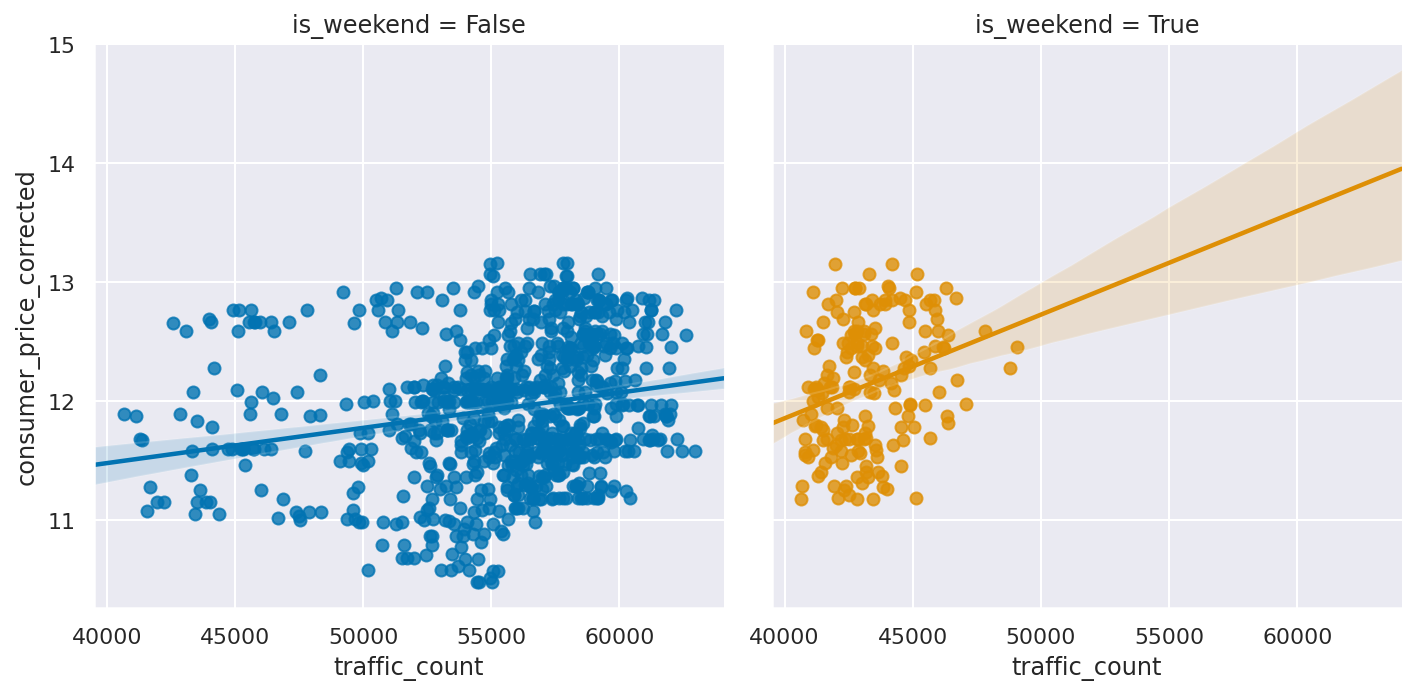

In [35]:
sns.lmplot(x="traffic_count", y="consumer_price_corrected", col="is_weekend", hue="is_weekend", data=df_traffic_gas, truncate=False);

Multiple other steps could be taken to improve the model, train it on the unexpected e.g. traffic accidents and road closures. It may also be expanded to take multiple roads in to consideration to grasp a bigger picture. In future work, the Danish Road Directorate might use this data to choose when to make road repairs, implying the road or some of the road will be closed. 


## Traffic and COVID-19

The traffic and COVID section gave an introductory and exploratory insight to possible relations between hospitalizations and traffic counts across three roads. Some clear patterns were found, especially during the initial restrictions and policies announced by the government in March 2022, where a drastic drop in traffic was found at all locations, while they slowly climbed back to a more stable level as the restrictions continued to be loosened. On an hourly basis, decreases in traffic across daytime hours were found at all streets; however, the nighttime hours were only slightly or not at all impacted.

The visualizations and accompanying explanations allowed for quick and intuitive conclusions to be made, and provided some fundamental insights into the data used. However, the analysis is somewhat rudimentary and does not delve into deeper or more specific patterns or utilize specific statistical tools such as machine learning to identify behaviours. An interesting aspect the analysis could be evolved towards, would be to cover many more streets in Copenhagen and compute some measure of impact each street had due to COVID - essentially mapping which parts of Copenhagen saw the biggest COVID-related impacts on traffic, perhaps combined with some animated video illustrating changes over time. Additionally, more analysis could be performed to uncover detailed differences of rush hour peaks and durations when comparing 2020 with the reference years.

# Contributions

While we have collaborated on many tasks within the group, the primary focuses of each group member are stated below.

* **s184192:** COVID-19/Traffic data analysis, data preparation, visualizations, discussion
* **s184230:** COVID-19/Gas price data analysis/ML, data extraction, motivation, visualizations & discussion
* **s184234:** Data cleaning and preprocessing, preliminary analysis, basic stats & genre, visualizations

# References

- [COVID-19 time line](http://thinkeuropa.dk/politik/tidslinje-over-coronakrisen-hvad-skete-der-og-hvornaar)
- [Consumer price index on gas](https://www.dst.dk/da/Statistik/emner/oekonomi/prisindeks/forbrugerprisindeks?tab=dok)
- [Encoding time](https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/)
- [Large increase in the number of cars on the roads](https://www.skm.dk/media/9140/aktuelle-skattetal-antal-biler-i-danmark.pdf)
- [Gas prices](https://www.drivkraftdanmark.dk/priser/benzin/)
- [Time between Symptom Onset, Hospitalisation and Recovery or Death: Statistical Analysis of Belgian COVID-19 Patients](https://www.mdpi.com/1660-4601/17/20/7560)